<a href="https://colab.research.google.com/github/trndnhan/Facial-Deepfake-Detection-with-ViT-and-CNN/blob/main/Thesis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library install & import

In [ ]:
!pip install peft

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import random
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification, Trainer, TrainingArguments, TrainerCallback, ResNetForImageClassification
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import DataLoader
import torch
import transformers
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from peft import LoraConfig, get_peft_model
import psutil

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Data exploration

In [ ]:
def count_files_in_subfolders(base_folder):
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    for subfolder in subfolders:
        num_files = len(os.listdir(subfolder))
        print(f"Folder {subfolder} contains {num_files} files")

In [32]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/CurrentTrainingData/real')

Folder /content/drive/MyDrive/Work/Thesis/CurrentTrainingData/real/subdataset_6 contains 1000 files


In [33]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/CurrentTrainingData/fake')

Folder /content/drive/MyDrive/Work/Thesis/CurrentTrainingData/fake/subdataset_6 contains 1000 files


In [ ]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/Data/train/real')

Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_38 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_39 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_40 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_2 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_3 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_4 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_5 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_6 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_7 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_8 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_9 contains 1000 fi

In [ ]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/Data/train/fake')

Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_39 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_38 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_40 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_2 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_3 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_4 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_5 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_6 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_7 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_8 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_9 contains 1000 fi

In [ ]:
def load_sample_images(base_folder, num_images=4):
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    sample_images = []

    for subfolder in subfolders:
        images = [os.path.join(subfolder, img) for img in os.listdir(subfolder) if img.endswith(('png', 'jpg', 'jpeg'))]
        random.shuffle(images)
        sample_images.extend(images[:num_images])
        if len(sample_images) >= num_images:
            break

    return sample_images[:num_images]

def display_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i, (img_path, label) in enumerate(zip(images, labels)):
        img = Image.open(img_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

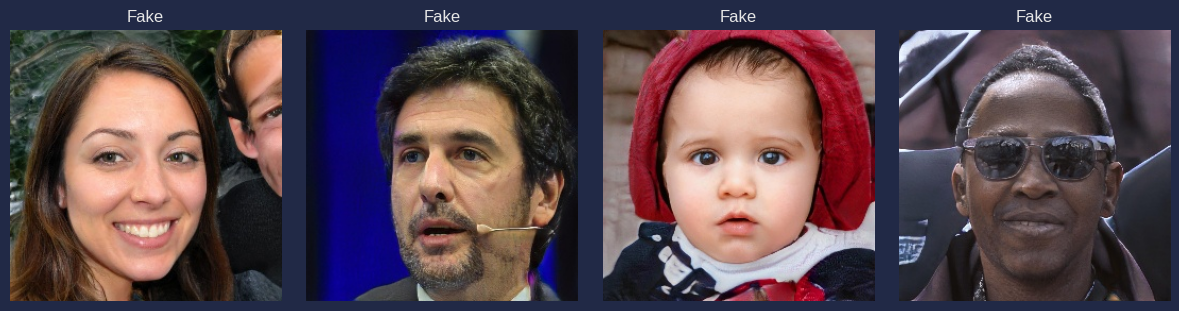

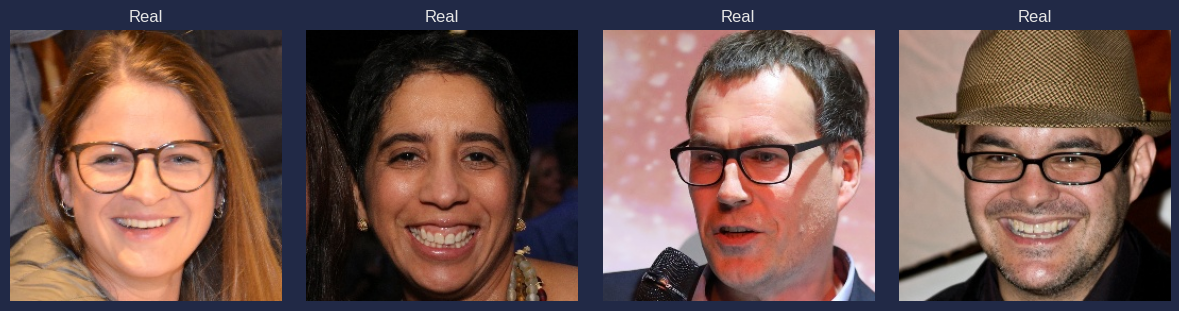

In [ ]:
# Define base folders for fake and real data
base_folder_fake = '/content/drive/MyDrive/Work/Thesis/Data/fake'
base_folder_real = '/content/drive/MyDrive/Work/Thesis/Data/real'

# Load sample images
fake_images = load_sample_images(base_folder_fake, num_images=4)
real_images = load_sample_images(base_folder_real, num_images=4)

# Display images
display_images(fake_images, ['Fake'] * len(fake_images))
display_images(real_images, ['Real'] * len(real_images))

# Data preprocessing & augmentation

In [ ]:
base_vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_model  = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
base_rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
rn_processor

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [ ]:
# Shared augmentation pipeline
augmentation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Color jitter
])

# Define the combined transform for ViT
train_vit_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_vit_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

# Define the combined transform for ResNet
train_resnet_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_resnet_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

In [34]:
# Load the dataset
dataset = ImageFolder(root='/content/drive/MyDrive/Work/Thesis/CurrentTrainingData')

In [ ]:
print(f"Training set size: {len(dataset)}")

Training set size: 2000


In [35]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return {"pixel_values": img, "labels": label}

# Wrap the datasets with the appropriate transforms
vit_train_dataset = CustomDataset(dataset, transform=train_vit_combined_transforms)

# Wrap the datasets with the appropriate transforms
rn_train_dataset = CustomDataset(dataset, transform=train_resnet_combined_transforms)

# Data after preprocessing

In [ ]:
def collect_images(dataset, num_images=4):
    fake_images = []
    real_images = []
    labels_dict = {0: 'fake', 1: 'real'}

    while len(fake_images) < num_images or len(real_images) < num_images:
        for i in range(len(dataset)):
            sample = dataset[i]
            img = sample["pixel_values"]
            label = sample["labels"]
            if label == 0 and len(fake_images) < num_images:
                fake_images.append((img, labels_dict[0]))
            elif label == 1 and len(real_images) < num_images:
                real_images.append((img, labels_dict[1]))
            if len(fake_images) >= num_images and len(real_images) >= num_images:
                break

    return fake_images, real_images

def visualize_fake_real_images(dataset, num_images=4):
    fake_images, real_images = collect_images(dataset, num_images)

    # Plot
    plt.figure(figsize=(12, 6))

    for i, (img, label) in enumerate(fake_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(label, fontsize=12)
        plt.axis('off')

    for i, (img, label) in enumerate(real_images):
        plt.subplot(2, 4, i + 5)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

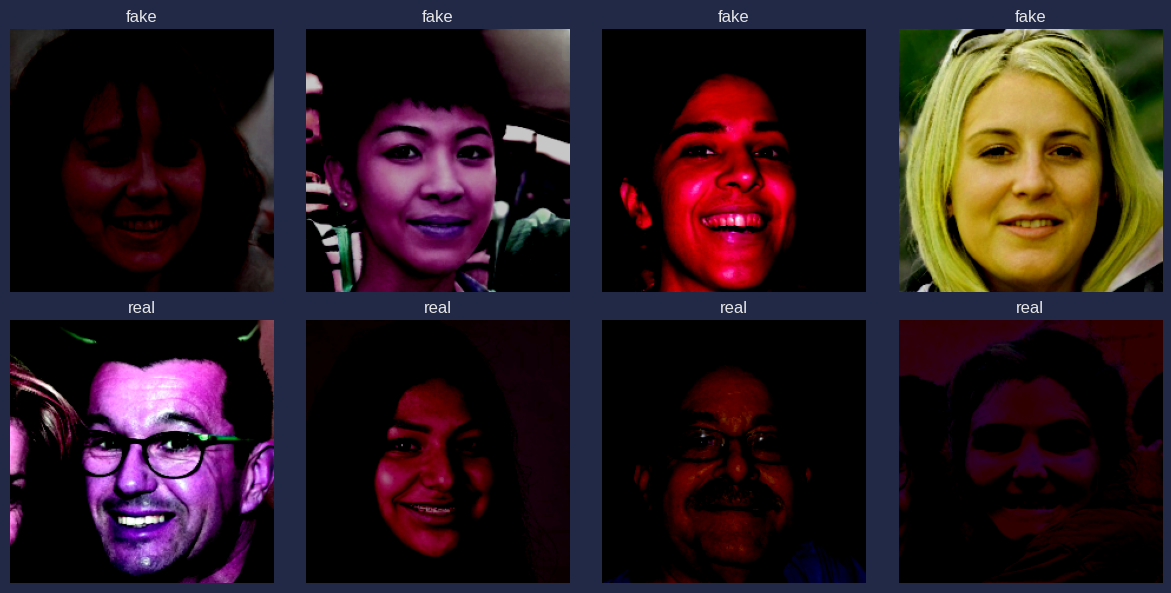

In [ ]:
visualize_fake_real_images(vit_train_dataset, num_images=4)

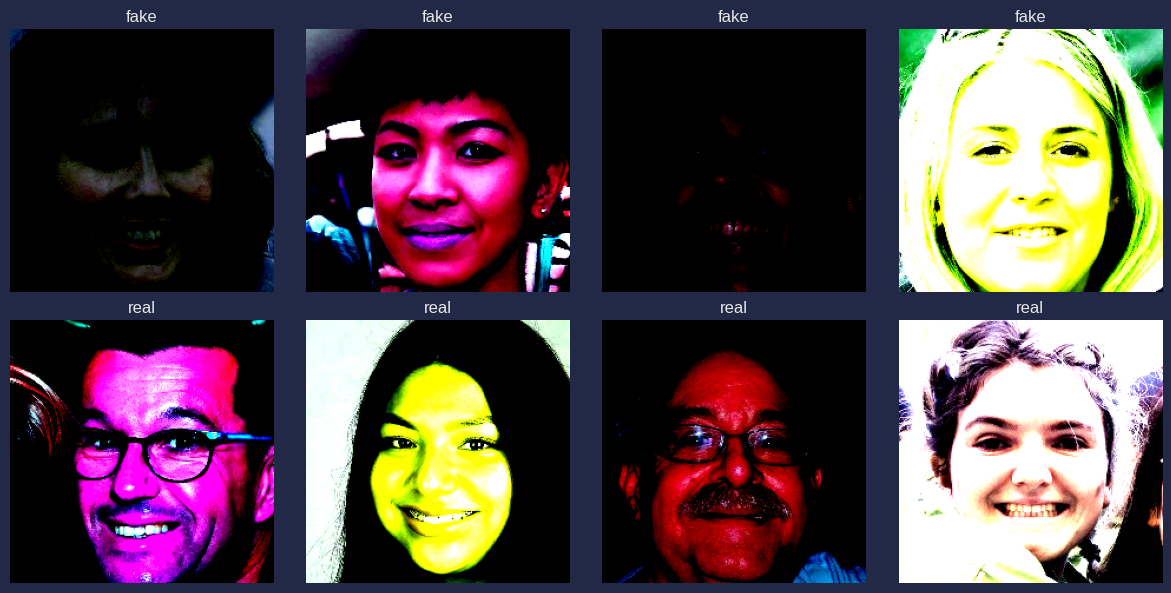

In [ ]:
visualize_fake_real_images(rn_train_dataset, num_images=4)

# Model overview

In [ ]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
rn_model

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
def count_trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad and param.numel() > 10000:
            print(f"Layer: {name} | Trainable parameters: {param.numel()}")

In [ ]:
print_trainable_parameters(vit_model)

trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [ ]:
print_trainable_parameters(rn_model)

trainable params: 23512130 || all params: 23512130 || trainable%: 100.00


In [ ]:
count_trainable_parameters(vit_model)

Layer: vit.embeddings.position_embeddings | Trainable parameters: 151296
Layer: vit.embeddings.patch_embeddings.projection.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.output.dense.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.intermediate.dense.weight | Trainable parameters: 2359296
Layer: vit.encoder.layer.0.output.dense.weight | Trainable parameters: 2359296
Layer: vit.encoder.layer.1.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.output.d

In [ ]:
count_trainable_parameters(rn_model)

Layer: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.0.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.0.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.1.layer.0.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.1.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.1.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.2.layer.0.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.2.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.2.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.1.layers.0.shortcut.convolution.weight | Trainable parameters: 131072
Layer: resnet.encoder.stage

In [ ]:
# Freeze every layer but the last layer
for param in vit_model.parameters():
    param.requires_grad = False
for param in rn_model.parameters():
    param.requires_grad = False
for param in base_vit_model.parameters():
    param.requires_grad = False
for param in base_rn_model.parameters():
    param.requires_grad = False

# Unfreeze the last layer of the base models
for param in base_vit_model.classifier.parameters():
    param.requires_grad = True
for param in base_rn_model.classifier.parameters():
    param.requires_grad = True

In [ ]:
vit_config = LoraConfig(
    r=1,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "layer.8.attention.attention.query",
        "layer.8.attention.attention.key",
        "layer.8.attention.attention.value"
        "layer.9.attention.attention.query",
        "layer.9.attention.attention.key",
        "layer.9.attention.attention.value",
        "layer.10.attention.attention.query",
        "layer.10.attention.attention.key",
        "layer.10.attention.attention.value",
        "layer.11.attention.attention.query",
        "layer.11.attention.attention.key",
        "layer.11.attention.attention.value"
    ]
)

rn_config = LoraConfig(
    r=1,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "layer.1.convolution"
    ]
)

vit_lora_model = get_peft_model(vit_model, vit_config)
rn_lora_model = get_peft_model(rn_model, rn_config)

In [ ]:
print_trainable_parameters(vit_lora_model)

trainable params: 16898 || all params: 85817092 || trainable%: 0.02


In [ ]:
print_trainable_parameters(rn_lora_model)

trainable params: 41858 || all params: 23553988 || trainable%: 0.18


In [ ]:
print_trainable_parameters(base_vit_model)

trainable params: 1538 || all params: 85800194 || trainable%: 0.00


In [ ]:
print_trainable_parameters(base_rn_model)

trainable params: 4098 || all params: 23512130 || trainable%: 0.02


# Prepare Trainer

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
class CustomTrainer(transformers.Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_predictions = []
        self.epoch_labels = []
        self.epoch_loss = []

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        MAX: Subclassed to compute training accuracy.

        How the loss is computed by Trainer. By default, all models return the loss in
        the first element.

        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)

        if "labels" in inputs:
            preds = outputs.logits.detach()

            # Store predictions and labels for epoch-level metrics
            self.epoch_predictions.append(preds.cpu().numpy())
            self.epoch_labels.append(inputs["labels"].cpu().numpy())

        # Save past state if it exists
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            self.epoch_loss.append(loss.item())  # Store loss for epoch-level metrics

        return (loss, outputs) if return_outputs else loss

In [ ]:
class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        # Aggregate predictions and labels for the entire epoch
        epoch_predictions = np.concatenate(self._trainer.epoch_predictions)
        epoch_labels = np.concatenate(self._trainer.epoch_labels)

        # Compute accuracy
        accuracy = np.mean(epoch_predictions.argmax(axis=1) == epoch_labels)

        # Compute mean loss
        mean_loss = np.mean(self._trainer.epoch_loss)

        # Compute precision, recall, and F1-score
        precision, recall, f1, _ = precision_recall_fscore_support(
            epoch_labels, epoch_predictions.argmax(axis=1), average="weighted"
        )

        # Print epoch-level metrics
        print(f"Accuracy: {accuracy:.4f}, Loss: {mean_loss:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        # Print memory usage
        process = psutil.Process()
        cpu_memory = process.memory_info().rss / (1024 ** 3)  # GB
        print(f"CPU memory usage: {cpu_memory:.2f} GB")

        # Clear stored predictions, labels, and loss for the next epoch
        self._trainer.epoch_predictions = []
        self._trainer.epoch_labels = []
        self._trainer.epoch_loss = []

        return None

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=1,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

# Training

## First epoch

### Training first subfolder (0.025 epoch)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train()

Accuracy: 0.5490, Loss: 0.6859
Precision: 0.5916, Recall: 0.5490, F1: 0.4897
CPU memory usage: 1.48 GB


TrainOutput(global_step=40, training_loss=0.6859185695648193, metrics={'train_runtime': 938.9016, 'train_samples_per_second': 2.13, 'train_steps_per_second': 0.043, 'total_flos': 4.247080685568e+16, 'train_loss': 0.6859185695648193, 'epoch': 1.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train()

Accuracy: 0.5215, Loss: 0.7186
Precision: 0.5222, Recall: 0.5215, F1: 0.5178
CPU memory usage: 3.00 GB


TrainOutput(global_step=40, training_loss=0.7185947895050049, metrics={'train_runtime': 1424.3228, 'train_samples_per_second': 1.404, 'train_steps_per_second': 0.028, 'total_flos': 1.54983979229184e+17, 'train_loss': 0.7185947895050049, 'epoch': 1.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train()

Accuracy: 0.5225, Loss: 0.6920
Precision: 0.5455, Recall: 0.5225, F1: 0.4534
CPU memory usage: 2.68 GB


TrainOutput(global_step=40, training_loss=0.6920181751251221, metrics={'train_runtime': 1969.1859, 'train_samples_per_second': 1.016, 'train_steps_per_second': 0.02, 'total_flos': 4.2546416467968e+16, 'train_loss': 0.6920181751251221, 'epoch': 1.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train()

Accuracy: 0.5460, Loss: 0.7185
Precision: 0.5598, Recall: 0.5460, F1: 0.5183
CPU memory usage: 4.53 GB


TrainOutput(global_step=40, training_loss=0.7184763431549073, metrics={'train_runtime': 1968.0411, 'train_samples_per_second': 1.016, 'train_steps_per_second': 0.02, 'total_flos': 1.55014502694912e+17, 'train_loss': 0.7184763431549073, 'epoch': 1.0})

###Training second subfolder (0.05 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=2,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5670, Loss: 0.6848
Precision: 0.6193, Recall: 0.5670, F1: 0.5137
CPU memory usage: 4.31 GB


TrainOutput(global_step=80, training_loss=0.34239802360534666, metrics={'train_runtime': 553.3389, 'train_samples_per_second': 7.229, 'train_steps_per_second': 0.145, 'total_flos': 8.494161371136e+16, 'train_loss': 0.34239802360534666, 'epoch': 2.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5305, Loss: 0.7241
Precision: 0.5324, Recall: 0.5305, F1: 0.5236
CPU memory usage: 4.37 GB


TrainOutput(global_step=80, training_loss=0.3620391607284546, metrics={'train_runtime': 1437.8414, 'train_samples_per_second': 2.782, 'train_steps_per_second': 0.056, 'total_flos': 3.09967958458368e+17, 'train_loss': 0.3620391607284546, 'epoch': 2.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5090, Loss: 0.6921
Precision: 0.5174, Recall: 0.5090, F1: 0.4418
CPU memory usage: 4.37 GB


TrainOutput(global_step=80, training_loss=0.34605860710144043, metrics={'train_runtime': 1315.6363, 'train_samples_per_second': 3.04, 'train_steps_per_second': 0.061, 'total_flos': 8.5092832935936e+16, 'train_loss': 0.34605860710144043, 'epoch': 2.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5490, Loss: 0.7039
Precision: 0.5539, Recall: 0.5490, F1: 0.5385
CPU memory usage: 4.99 GB


TrainOutput(global_step=80, training_loss=0.35194251537322996, metrics={'train_runtime': 2347.4005, 'train_samples_per_second': 1.704, 'train_steps_per_second': 0.034, 'total_flos': 3.10029005389824e+17, 'train_loss': 0.35194251537322996, 'epoch': 2.0})

###Training third subfolder (0.075 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=3,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5740, Loss: 0.6838
Precision: 0.6174, Recall: 0.5740, F1: 0.5306
CPU memory usage: 4.31 GB


TrainOutput(global_step=120, training_loss=0.22794539133707684, metrics={'train_runtime': 919.5411, 'train_samples_per_second': 6.525, 'train_steps_per_second': 0.13, 'total_flos': 1.2741242056704e+17, 'train_loss': 0.22794539133707684, 'epoch': 3.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5400, Loss: 0.7037
Precision: 0.5419, Recall: 0.5400, F1: 0.5348
CPU memory usage: 2.00 GB


TrainOutput(global_step=120, training_loss=0.23457024892171224, metrics={'train_runtime': 1810.4837, 'train_samples_per_second': 3.314, 'train_steps_per_second': 0.066, 'total_flos': 4.64951937687552e+17, 'train_loss': 0.23457024892171224, 'epoch': 3.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5125, Loss: 0.6902
Precision: 0.5226, Recall: 0.5125, F1: 0.4511
CPU memory usage: 6.26 GB


TrainOutput(global_step=120, training_loss=0.23005019823710124, metrics={'train_runtime': 1570.0815, 'train_samples_per_second': 3.821, 'train_steps_per_second': 0.076, 'total_flos': 1.27639249403904e+17, 'train_loss': 0.23005019823710124, 'epoch': 3.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6733
Precision: 0.5946, Recall: 0.5935, F1: 0.5923
CPU memory usage: 6.92 GB


TrainOutput(global_step=120, training_loss=0.22441884676615398, metrics={'train_runtime': 2101.8367, 'train_samples_per_second': 2.855, 'train_steps_per_second': 0.057, 'total_flos': 4.65043508084736e+17, 'train_loss': 0.22441884676615398, 'epoch': 3.0})

###Training fourth subfolder (0.1 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=4,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5795, Loss: 0.6833
Precision: 0.6200, Recall: 0.5795, F1: 0.5407
CPU memory usage: 1.28 GB


TrainOutput(global_step=160, training_loss=0.17083740234375, metrics={'train_runtime': 1012.6191, 'train_samples_per_second': 7.9, 'train_steps_per_second': 0.158, 'total_flos': 1.6988322742272e+17, 'train_loss': 0.17083740234375, 'epoch': 4.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5550, Loss: 0.6971
Precision: 0.5568, Recall: 0.5550, F1: 0.5515
CPU memory usage: 4.64 GB


TrainOutput(global_step=160, training_loss=0.1742812752723694, metrics={'train_runtime': 1401.4259, 'train_samples_per_second': 5.708, 'train_steps_per_second': 0.114, 'total_flos': 6.19935916916736e+17, 'train_loss': 0.1742812752723694, 'epoch': 4.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5440, Loss: 0.6894
Precision: 0.5780, Recall: 0.5440, F1: 0.4883
CPU memory usage: 4.84 GB


TrainOutput(global_step=160, training_loss=0.17235071659088136, metrics={'train_runtime': 1307.3677, 'train_samples_per_second': 6.119, 'train_steps_per_second': 0.122, 'total_flos': 1.70185665871872e+17, 'train_loss': 0.17235071659088136, 'epoch': 4.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5995, Loss: 0.6643
Precision: 0.5996, Recall: 0.5995, F1: 0.5994
CPU memory usage: 4.15 GB


TrainOutput(global_step=160, training_loss=0.16607903242111205, metrics={'train_runtime': 2434.8418, 'train_samples_per_second': 3.286, 'train_steps_per_second': 0.066, 'total_flos': 6.20058010779648e+17, 'train_loss': 0.16607903242111205, 'epoch': 4.0})

###Training fifth subfolder (0.125 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=5,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5950, Loss: 0.6824
Precision: 0.6384, Recall: 0.5950, F1: 0.5605
CPU memory usage: 1.22 GB


TrainOutput(global_step=200, training_loss=0.13647119522094728, metrics={'train_runtime': 1047.6501, 'train_samples_per_second': 9.545, 'train_steps_per_second': 0.191, 'total_flos': 2.123540342784e+17, 'train_loss': 0.13647119522094728, 'epoch': 5.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5525, Loss: 0.7013
Precision: 0.5549, Recall: 0.5525, F1: 0.5476
CPU memory usage: 3.01 GB


TrainOutput(global_step=200, training_loss=0.14025315284729004, metrics={'train_runtime': 1231.5001, 'train_samples_per_second': 8.12, 'train_steps_per_second': 0.162, 'total_flos': 7.7491989614592e+17, 'train_loss': 0.14025315284729004, 'epoch': 5.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5385, Loss: 0.6891
Precision: 0.5598, Recall: 0.5385, F1: 0.4934
CPU memory usage: 2.69 GB


TrainOutput(global_step=200, training_loss=0.13781007766723632, metrics={'train_runtime': 1315.4488, 'train_samples_per_second': 7.602, 'train_steps_per_second': 0.152, 'total_flos': 2.1273208233984e+17, 'train_loss': 0.13781007766723632, 'epoch': 5.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6030, Loss: 0.6676
Precision: 0.6030, Recall: 0.6030, F1: 0.6030
CPU memory usage: 4.92 GB


TrainOutput(global_step=200, training_loss=0.1335196590423584, metrics={'train_runtime': 1747.8204, 'train_samples_per_second': 5.721, 'train_steps_per_second': 0.114, 'total_flos': 7.7507251347456e+17, 'train_loss': 0.1335196590423584, 'epoch': 5.0})

###Training sixth subfolder (0.15 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=6,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5855, Loss: 0.6823
Precision: 0.6224, Recall: 0.5855, F1: 0.5517
CPU memory usage: 1.44 GB


TrainOutput(global_step=240, training_loss=0.11371860504150391, metrics={'train_runtime': 1267.7795, 'train_samples_per_second': 9.465, 'train_steps_per_second': 0.189, 'total_flos': 2.5482484113408e+17, 'train_loss': 0.11371860504150391, 'epoch': 6.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5655, Loss: 0.6903
Precision: 0.5681, Recall: 0.5655, F1: 0.5613
CPU memory usage: 5.25 GB


TrainOutput(global_step=240, training_loss=0.11505028406778971, metrics={'train_runtime': 1331.8321, 'train_samples_per_second': 9.01, 'train_steps_per_second': 0.18, 'total_flos': 9.29903875375104e+17, 'train_loss': 0.11505028406778971, 'epoch': 6.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5530, Loss: 0.6882
Precision: 0.5906, Recall: 0.5530, F1: 0.5013
CPU memory usage: 4.85 GB


TrainOutput(global_step=240, training_loss=0.11469479401906331, metrics={'train_runtime': 1458.714, 'train_samples_per_second': 8.226, 'train_steps_per_second': 0.165, 'total_flos': 2.55278498807808e+17, 'train_loss': 0.11469479401906331, 'epoch': 6.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6175, Loss: 0.6563
Precision: 0.6178, Recall: 0.6175, F1: 0.6172
CPU memory usage: 7.78 GB


TrainOutput(global_step=240, training_loss=0.10938201745351156, metrics={'train_runtime': 1706.5987, 'train_samples_per_second': 7.032, 'train_steps_per_second': 0.141, 'total_flos': 9.30087016169472e+17, 'train_loss': 0.10938201745351156, 'epoch': 6.0})

###Training seventh subfolder (0.175 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=7,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5860, Loss: 0.6838
Precision: 0.6237, Recall: 0.5860, F1: 0.5519
CPU memory usage: 1.36 GB


TrainOutput(global_step=280, training_loss=0.09768206051417759, metrics={'train_runtime': 791.1273, 'train_samples_per_second': 17.696, 'train_steps_per_second': 0.354, 'total_flos': 2.9729564798976e+17, 'train_loss': 0.09768206051417759, 'epoch': 7.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5655, Loss: 0.6847
Precision: 0.5685, Recall: 0.5655, F1: 0.5607
CPU memory usage: 1.92 GB


TrainOutput(global_step=280, training_loss=0.09781560897827149, metrics={'train_runtime': 1585.2456, 'train_samples_per_second': 8.831, 'train_steps_per_second': 0.177, 'total_flos': 1.084887854604288e+18, 'train_loss': 0.09781560897827149, 'epoch': 7.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5605, Loss: 0.6871
Precision: 0.5958, Recall: 0.5605, F1: 0.5159
CPU memory usage: 3.08 GB


TrainOutput(global_step=280, training_loss=0.09815809386117118, metrics={'train_runtime': 1405.4806, 'train_samples_per_second': 9.961, 'train_steps_per_second': 0.199, 'total_flos': 2.97824915275776e+17, 'train_loss': 0.09815809386117118, 'epoch': 7.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6000, Loss: 0.6631
Precision: 0.6000, Recall: 0.6000, F1: 0.6000
CPU memory usage: 5.36 GB


TrainOutput(global_step=280, training_loss=0.09473013196672712, metrics={'train_runtime': 2006.2077, 'train_samples_per_second': 6.978, 'train_steps_per_second': 0.14, 'total_flos': 1.085101518864384e+18, 'train_loss': 0.09473013196672712, 'epoch': 7.0})

###Training eighth subfolder (0.2 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=8,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5990, Loss: 0.6824
Precision: 0.6345, Recall: 0.5990, F1: 0.5706
CPU memory usage: 5.36 GB


TrainOutput(global_step=320, training_loss=0.08529695868492126, metrics={'train_runtime': 840.4679, 'train_samples_per_second': 19.037, 'train_steps_per_second': 0.381, 'total_flos': 3.3976645484544e+17, 'train_loss': 0.08529695868492126, 'epoch': 8.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5670, Loss: 0.6957
Precision: 0.5710, Recall: 0.5670, F1: 0.5609
CPU memory usage: 1.72 GB


TrainOutput(global_step=320, training_loss=0.08696720600128174, metrics={'train_runtime': 1656.827, 'train_samples_per_second': 9.657, 'train_steps_per_second': 0.193, 'total_flos': 1.239871833833472e+18, 'train_loss': 0.08696720600128174, 'epoch': 8.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5415, Loss: 0.6888
Precision: 0.5640, Recall: 0.5415, F1: 0.4973
CPU memory usage: 2.74 GB


TrainOutput(global_step=320, training_loss=0.08610387444496155, metrics={'train_runtime': 1308.4548, 'train_samples_per_second': 12.228, 'train_steps_per_second': 0.245, 'total_flos': 3.40371331743744e+17, 'train_loss': 0.08610387444496155, 'epoch': 8.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6290, Loss: 0.6528
Precision: 0.6298, Recall: 0.6290, F1: 0.6284
CPU memory usage: 5.37 GB


TrainOutput(global_step=320, training_loss=0.08160330653190613, metrics={'train_runtime': 1700.3293, 'train_samples_per_second': 9.41, 'train_steps_per_second': 0.188, 'total_flos': 1.240116021559296e+18, 'train_loss': 0.08160330653190613, 'epoch': 8.0})

###Training ninth subfolder (0.225 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=9,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5970, Loss: 0.6832
Precision: 0.6280, Recall: 0.5970, F1: 0.5710
CPU memory usage: 1.47 GB


TrainOutput(global_step=360, training_loss=0.0759073363410102, metrics={'train_runtime': 2009.7863, 'train_samples_per_second': 8.956, 'train_steps_per_second': 0.179, 'total_flos': 3.8223726170112e+17, 'train_loss': 0.0759073363410102, 'epoch': 9.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5930, Loss: 0.6743
Precision: 0.5975, Recall: 0.5930, F1: 0.5883
CPU memory usage: 1.91 GB


TrainOutput(global_step=360, training_loss=0.07492644521925185, metrics={'train_runtime': 1517.6509, 'train_samples_per_second': 11.86, 'train_steps_per_second': 0.237, 'total_flos': 1.394855813062656e+18, 'train_loss': 0.07492644521925185, 'epoch': 9.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5740, Loss: 0.6865
Precision: 0.6078, Recall: 0.5740, F1: 0.5378
CPU memory usage: 3.17 GB


TrainOutput(global_step=360, training_loss=0.07627568774753146, metrics={'train_runtime': 1375.666, 'train_samples_per_second': 13.085, 'train_steps_per_second': 0.262, 'total_flos': 3.82917748211712e+17, 'train_loss': 0.07627568774753146, 'epoch': 9.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6210, Loss: 0.6543
Precision: 0.6222, Recall: 0.6210, F1: 0.6201
CPU memory usage: 5.27 GB


TrainOutput(global_step=360, training_loss=0.07269598642985026, metrics={'train_runtime': 1927.1728, 'train_samples_per_second': 9.34, 'train_steps_per_second': 0.187, 'total_flos': 1.395130524254208e+18, 'train_loss': 0.07269598642985026, 'epoch': 9.0})

###Training tenth subfolder (0.25 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=10,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5830, Loss: 0.6839
Precision: 0.6078, Recall: 0.5830, F1: 0.5575
CPU memory usage: 5.09 GB


TrainOutput(global_step=400, training_loss=0.06838658332824707, metrics={'train_runtime': 1794.8131, 'train_samples_per_second': 11.143, 'train_steps_per_second': 0.223, 'total_flos': 4.247080685568e+17, 'train_loss': 0.06838658332824707, 'epoch': 10.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5835, Loss: 0.6783
Precision: 0.5870, Recall: 0.5835, F1: 0.5793
CPU memory usage: 4.49 GB


TrainOutput(global_step=400, training_loss=0.06783483505249023, metrics={'train_runtime': 1403.8843, 'train_samples_per_second': 14.246, 'train_steps_per_second': 0.285, 'total_flos': 1.54983979229184e+18, 'train_loss': 0.06783483505249023, 'epoch': 10.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5555, Loss: 0.6879
Precision: 0.5775, Recall: 0.5555, F1: 0.5215
CPU memory usage: 4.52 GB


TrainOutput(global_step=400, training_loss=0.06879109382629395, metrics={'train_runtime': 1284.4222, 'train_samples_per_second': 15.571, 'train_steps_per_second': 0.311, 'total_flos': 4.2546416467968e+17, 'train_loss': 0.06879109382629395, 'epoch': 10.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6195, Loss: 0.6523
Precision: 0.6227, Recall: 0.6195, F1: 0.6170
CPU memory usage: 4.43 GB


TrainOutput(global_step=400, training_loss=0.06523365497589112, metrics={'train_runtime': 1937.5462, 'train_samples_per_second': 10.322, 'train_steps_per_second': 0.206, 'total_flos': 1.55014502694912e+18, 'train_loss': 0.06523365497589112, 'epoch': 10.0})

###Training eleventh subfolder (0.275 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=11,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5925, Loss: 0.6831
Precision: 0.6189, Recall: 0.5925, F1: 0.5686
CPU memory usage: 1.38 GB


TrainOutput(global_step=440, training_loss=0.06210248253562234, metrics={'train_runtime': 1255.1258, 'train_samples_per_second': 17.528, 'train_steps_per_second': 0.351, 'total_flos': 4.6717887541248e+17, 'train_loss': 0.06210248253562234, 'epoch': 11.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5820, Loss: 0.6730
Precision: 0.5863, Recall: 0.5820, F1: 0.5767
CPU memory usage: 1.87 GB


TrainOutput(global_step=440, training_loss=0.061181215806440876, metrics={'train_runtime': 1614.2039, 'train_samples_per_second': 13.629, 'train_steps_per_second': 0.273, 'total_flos': 1.704823771521024e+18, 'train_loss': 0.061181215806440876, 'epoch': 11.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5615, Loss: 0.6877
Precision: 0.5903, Recall: 0.5615, F1: 0.5235
CPU memory usage: 2.74 GB


TrainOutput(global_step=440, training_loss=0.0625190561467951, metrics={'train_runtime': 1650.4914, 'train_samples_per_second': 13.329, 'train_steps_per_second': 0.267, 'total_flos': 4.68010581147648e+17, 'train_loss': 0.0625190561467951, 'epoch': 11.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6260, Loss: 0.6494
Precision: 0.6269, Recall: 0.6260, F1: 0.6254
CPU memory usage: 4.62 GB


TrainOutput(global_step=440, training_loss=0.05903199369257146, metrics={'train_runtime': 1691.158, 'train_samples_per_second': 13.009, 'train_steps_per_second': 0.26, 'total_flos': 1.705159529644032e+18, 'train_loss': 0.05903199369257146, 'epoch': 11.0})

###Training twelfth subfolder (0.3 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=12,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6035, Loss: 0.6825
Precision: 0.6421, Recall: 0.6035, F1: 0.5746
CPU memory usage: 1.43 GB


TrainOutput(global_step=480, training_loss=0.056878785292307533, metrics={'train_runtime': 1572.4314, 'train_samples_per_second': 15.263, 'train_steps_per_second': 0.305, 'total_flos': 5.0964968226816e+17, 'train_loss': 0.056878785292307533, 'epoch': 12.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5850, Loss: 0.6690
Precision: 0.5899, Recall: 0.5850, F1: 0.5792
CPU memory usage: 1.86 GB


TrainOutput(global_step=480, training_loss=0.05575118859608968, metrics={'train_runtime': 1596.7175, 'train_samples_per_second': 15.031, 'train_steps_per_second': 0.301, 'total_flos': 1.859807750750208e+18, 'train_loss': 0.05575118859608968, 'epoch': 12.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5695, Loss: 0.6873
Precision: 0.6031, Recall: 0.5695, F1: 0.5313
CPU memory usage: 3.10 GB


TrainOutput(global_step=480, training_loss=0.05727569262186686, metrics={'train_runtime': 1467.4954, 'train_samples_per_second': 16.354, 'train_steps_per_second': 0.327, 'total_flos': 5.10556997615616e+17, 'train_loss': 0.05727569262186686, 'epoch': 12.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6110, Loss: 0.6567
Precision: 0.6119, Recall: 0.6110, F1: 0.6102
CPU memory usage: 5.03 GB


TrainOutput(global_step=480, training_loss=0.05472585360209147, metrics={'train_runtime': 2005.3133, 'train_samples_per_second': 11.968, 'train_steps_per_second': 0.239, 'total_flos': 1.860174032338944e+18, 'train_loss': 0.05472585360209147, 'epoch': 12.0})

###Training thirteenth subfolder (0.325 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=13,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5830, Loss: 0.6829
Precision: 0.6073, Recall: 0.5830, F1: 0.5580
CPU memory usage: 1.51 GB


TrainOutput(global_step=520, training_loss=0.05253292413858267, metrics={'train_runtime': 1250.7676, 'train_samples_per_second': 20.787, 'train_steps_per_second': 0.416, 'total_flos': 5.5212048912384e+17, 'train_loss': 0.05253292413858267, 'epoch': 13.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5810, Loss: 0.6805
Precision: 0.5842, Recall: 0.5810, F1: 0.5769
CPU memory usage: 1.92 GB


TrainOutput(global_step=520, training_loss=0.05234560232896071, metrics={'train_runtime': 1462.2055, 'train_samples_per_second': 17.781, 'train_steps_per_second': 0.356, 'total_flos': 2.014791729979392e+18, 'train_loss': 0.05234560232896071, 'epoch': 13.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5490, Loss: 0.6879
Precision: 0.5705, Recall: 0.5490, F1: 0.5118
CPU memory usage: 3.06 GB


TrainOutput(global_step=520, training_loss=0.052912028019244856, metrics={'train_runtime': 1399.9831, 'train_samples_per_second': 18.572, 'train_steps_per_second': 0.371, 'total_flos': 5.53103414083584e+17, 'train_loss': 0.052912028019244856, 'epoch': 13.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6405, Loss: 0.6411
Precision: 0.6427, Recall: 0.6405, F1: 0.6391
CPU memory usage: 5.24 GB


TrainOutput(global_step=520, training_loss=0.04931541222792405, metrics={'train_runtime': 1721.9506, 'train_samples_per_second': 15.099, 'train_steps_per_second': 0.302, 'total_flos': 2.015188535033856e+18, 'train_loss': 0.04931541222792405, 'epoch': 13.0})

###Training fourteenth subfolder (0.35 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=14,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5920, Loss: 0.6826
Precision: 0.6172, Recall: 0.5920, F1: 0.5688
CPU memory usage: 4.99 GB


TrainOutput(global_step=560, training_loss=0.04875843184334891, metrics={'train_runtime': 1196.9609, 'train_samples_per_second': 23.393, 'train_steps_per_second': 0.468, 'total_flos': 5.9459129597952e+17, 'train_loss': 0.04875843184334891, 'epoch': 14.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6095, Loss: 0.6577
Precision: 0.6132, Recall: 0.6095, F1: 0.6063
CPU memory usage: 1.79 GB


TrainOutput(global_step=560, training_loss=0.046978058133806504, metrics={'train_runtime': 2164.9191, 'train_samples_per_second': 12.934, 'train_steps_per_second': 0.259, 'total_flos': 2.169775709208576e+18, 'train_loss': 0.046978058133806504, 'epoch': 14.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5505, Loss: 0.6868
Precision: 0.5718, Recall: 0.5505, F1: 0.5144
CPU memory usage: 3.07 GB


TrainOutput(global_step=560, training_loss=0.04905501093183245, metrics={'train_runtime': 1427.0763, 'train_samples_per_second': 19.621, 'train_steps_per_second': 0.392, 'total_flos': 5.95649830551552e+17, 'train_loss': 0.04905501093183245, 'epoch': 14.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6385, Loss: 0.6355
Precision: 0.6402, Recall: 0.6385, F1: 0.6374
CPU memory usage: 5.13 GB


TrainOutput(global_step=560, training_loss=0.04539069788796561, metrics={'train_runtime': 1985.0197, 'train_samples_per_second': 14.106, 'train_steps_per_second': 0.282, 'total_flos': 2.170203037728768e+18, 'train_loss': 0.04539069788796561, 'epoch': 14.0})

###Training fifteenth subfolder (0.375 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=15,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5955, Loss: 0.6822
Precision: 0.6239, Recall: 0.5955, F1: 0.5709
CPU memory usage: 5.22 GB


TrainOutput(global_step=600, training_loss=0.04548086166381836, metrics={'train_runtime': 1223.5313, 'train_samples_per_second': 24.519, 'train_steps_per_second': 0.49, 'total_flos': 6.370621028352e+17, 'train_loss': 0.04548086166381836, 'epoch': 15.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6020, Loss: 0.6695
Precision: 0.6064, Recall: 0.6020, F1: 0.5978
CPU memory usage: 5.19 GB


TrainOutput(global_step=600, training_loss=0.044634459813435876, metrics={'train_runtime': 1415.8567, 'train_samples_per_second': 21.189, 'train_steps_per_second': 0.424, 'total_flos': 2.32475968843776e+18, 'train_loss': 0.044634459813435876, 'epoch': 15.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5515, Loss: 0.6885
Precision: 0.5717, Recall: 0.5515, F1: 0.5175
CPU memory usage: 5.12 GB


TrainOutput(global_step=600, training_loss=0.04589932441711426, metrics={'train_runtime': 1469.083, 'train_samples_per_second': 20.421, 'train_steps_per_second': 0.408, 'total_flos': 6.3819624701952e+17, 'train_loss': 0.04589932441711426, 'epoch': 15.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6295, Loss: 0.6453
Precision: 0.6314, Recall: 0.6295, F1: 0.6282
CPU memory usage: 6.44 GB


TrainOutput(global_step=600, training_loss=0.04301957130432129, metrics={'train_runtime': 2006.5577, 'train_samples_per_second': 14.951, 'train_steps_per_second': 0.299, 'total_flos': 2.32521754042368e+18, 'train_loss': 0.04301957130432129, 'epoch': 15.0})

###Training sixteenth subfolder (0.4 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=16,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6005, Loss: 0.6819
Precision: 0.6314, Recall: 0.6005, F1: 0.5755
CPU memory usage: 6.44 GB


TrainOutput(global_step=640, training_loss=0.04261850416660309, metrics={'train_runtime': 1239.0416, 'train_samples_per_second': 25.826, 'train_steps_per_second': 0.517, 'total_flos': 6.7953290969088e+17, 'train_loss': 0.04261850416660309, 'epoch': 16.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5915, Loss: 0.6715
Precision: 0.5957, Recall: 0.5915, F1: 0.5870
CPU memory usage: 6.41 GB


TrainOutput(global_step=640, training_loss=0.04197165668010712, metrics={'train_runtime': 1443.7712, 'train_samples_per_second': 22.164, 'train_steps_per_second': 0.443, 'total_flos': 2.479743667666944e+18, 'train_loss': 0.04197165668010712, 'epoch': 16.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5665, Loss: 0.6869
Precision: 0.5974, Recall: 0.5665, F1: 0.5292
CPU memory usage: 2.19 GB


TrainOutput(global_step=640, training_loss=0.04292966425418854, metrics={'train_runtime': 1976.7248, 'train_samples_per_second': 16.188, 'train_steps_per_second': 0.324, 'total_flos': 6.80742663487488e+17, 'train_loss': 0.04292966425418854, 'epoch': 16.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6345, Loss: 0.6448
Precision: 0.6359, Recall: 0.6345, F1: 0.6335
CPU memory usage: 4.61 GB


TrainOutput(global_step=640, training_loss=0.0403022050857544, metrics={'train_runtime': 1706.0623, 'train_samples_per_second': 18.757, 'train_steps_per_second': 0.375, 'total_flos': 2.480232043118592e+18, 'train_loss': 0.0403022050857544, 'epoch': 16.0})

###Training seventeenth subfolder (0.425 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=17,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6823
Precision: 0.6163, Recall: 0.5935, F1: 0.5725
CPU memory usage: 1.44 GB


TrainOutput(global_step=680, training_loss=0.04013787437887753, metrics={'train_runtime': 1167.5826, 'train_samples_per_second': 29.12, 'train_steps_per_second': 0.582, 'total_flos': 7.2200371654656e+17, 'train_loss': 0.04013787437887753, 'epoch': 17.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6035, Loss: 0.6739
Precision: 0.6080, Recall: 0.6035, F1: 0.5993
CPU memory usage: 2.03 GB


TrainOutput(global_step=680, training_loss=0.03964033687815947, metrics={'train_runtime': 1858.3578, 'train_samples_per_second': 18.296, 'train_steps_per_second': 0.366, 'total_flos': 2.634727646896128e+18, 'train_loss': 0.03964033687815947, 'epoch': 17.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5775, Loss: 0.6855
Precision: 0.6086, Recall: 0.5775, F1: 0.5449
CPU memory usage: 3.08 GB


TrainOutput(global_step=680, training_loss=0.04032605676090016, metrics={'train_runtime': 1422.2309, 'train_samples_per_second': 23.906, 'train_steps_per_second': 0.478, 'total_flos': 7.23289079955456e+17, 'train_loss': 0.04032605676090016, 'epoch': 17.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6395, Loss: 0.6417
Precision: 0.6416, Recall: 0.6395, F1: 0.6382
CPU memory usage: 4.87 GB


TrainOutput(global_step=680, training_loss=0.03774714750402114, metrics={'train_runtime': 1975.3215, 'train_samples_per_second': 17.212, 'train_steps_per_second': 0.344, 'total_flos': 2.635246545813504e+18, 'train_loss': 0.03774714750402114, 'epoch': 17.0})

###Training eighteenth subfolder (0.45 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=18,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5985, Loss: 0.6821
Precision: 0.6257, Recall: 0.5985, F1: 0.5756
CPU memory usage: 4.82 GB


TrainOutput(global_step=720, training_loss=0.037891798549228244, metrics={'train_runtime': 807.7428, 'train_samples_per_second': 44.569, 'train_steps_per_second': 0.891, 'total_flos': 7.6447452340224e+17, 'train_loss': 0.037891798549228244, 'epoch': 18.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5845, Loss: 0.6738
Precision: 0.5881, Recall: 0.5845, F1: 0.5803
CPU memory usage: 4.53 GB


TrainOutput(global_step=720, training_loss=0.037432596418592666, metrics={'train_runtime': 1447.3093, 'train_samples_per_second': 24.874, 'train_steps_per_second': 0.497, 'total_flos': 2.789711626125312e+18, 'train_loss': 0.037432596418592666, 'epoch': 18.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5565, Loss: 0.6869
Precision: 0.5792, Recall: 0.5565, F1: 0.5223
CPU memory usage: 4.55 GB


TrainOutput(global_step=720, training_loss=0.03816346062554254, metrics={'train_runtime': 1370.2584, 'train_samples_per_second': 26.272, 'train_steps_per_second': 0.525, 'total_flos': 7.65835496423424e+17, 'train_loss': 0.03816346062554254, 'epoch': 18.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6375, Loss: 0.6403
Precision: 0.6393, Recall: 0.6375, F1: 0.6363
CPU memory usage: 5.11 GB


TrainOutput(global_step=720, training_loss=0.03557135528988308, metrics={'train_runtime': 1949.6128, 'train_samples_per_second': 18.465, 'train_steps_per_second': 0.369, 'total_flos': 2.790261048508416e+18, 'train_loss': 0.03557135528988308, 'epoch': 18.0})

###Training nineteenth subfolder (0.475 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=19,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6165, Loss: 0.6801
Precision: 0.6449, Recall: 0.6165, F1: 0.5967
CPU memory usage: 5.11 GB


TrainOutput(global_step=760, training_loss=0.03579321660493549, metrics={'train_runtime': 1037.5203, 'train_samples_per_second': 36.626, 'train_steps_per_second': 0.733, 'total_flos': 8.0694533025792e+17, 'train_loss': 0.03579321660493549, 'epoch': 19.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6185, Loss: 0.6623
Precision: 0.6230, Recall: 0.6185, F1: 0.6150
CPU memory usage: 5.11 GB


TrainOutput(global_step=760, training_loss=0.03485579239694696, metrics={'train_runtime': 1406.9296, 'train_samples_per_second': 27.009, 'train_steps_per_second': 0.54, 'total_flos': 2.944695605354496e+18, 'train_loss': 0.03485579239694696, 'epoch': 19.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5805, Loss: 0.6860
Precision: 0.6167, Recall: 0.5805, F1: 0.5452
CPU memory usage: 5.12 GB


TrainOutput(global_step=760, training_loss=0.03610288971348813, metrics={'train_runtime': 1267.9796, 'train_samples_per_second': 29.969, 'train_steps_per_second': 0.599, 'total_flos': 8.08381912891392e+17, 'train_loss': 0.03610288971348813, 'epoch': 19.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6250, Loss: 0.6433
Precision: 0.6262, Recall: 0.6250, F1: 0.6241
CPU memory usage: 5.10 GB


TrainOutput(global_step=760, training_loss=0.03385793535332931, metrics={'train_runtime': 1958.1965, 'train_samples_per_second': 19.406, 'train_steps_per_second': 0.388, 'total_flos': 2.945275551203328e+18, 'train_loss': 0.03385793535332931, 'epoch': 19.0})

###Training twentieth subfolder (0.5 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=20,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5960, Loss: 0.6819
Precision: 0.6193, Recall: 0.5960, F1: 0.5753
CPU memory usage: 5.10 GB


TrainOutput(global_step=800, training_loss=0.03409597873687744, metrics={'train_runtime': 845.4805, 'train_samples_per_second': 47.31, 'train_steps_per_second': 0.946, 'total_flos': 8.494161371136e+17, 'train_loss': 0.03409597873687744, 'epoch': 20.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6010, Loss: 0.6629
Precision: 0.6055, Recall: 0.6010, F1: 0.5967
CPU memory usage: 4.90 GB


TrainOutput(global_step=800, training_loss=0.033143002986907956, metrics={'train_runtime': 1441.3612, 'train_samples_per_second': 27.752, 'train_steps_per_second': 0.555, 'total_flos': 3.09967958458368e+18, 'train_loss': 0.033143002986907956, 'epoch': 20.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5635, Loss: 0.6872
Precision: 0.5901, Recall: 0.5635, F1: 0.5288
CPU memory usage: 2.62 GB


TrainOutput(global_step=800, training_loss=0.03436163902282715, metrics={'train_runtime': 1607.8252, 'train_samples_per_second': 24.878, 'train_steps_per_second': 0.498, 'total_flos': 8.5092832935936e+17, 'train_loss': 0.03436163902282715, 'epoch': 20.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6370, Loss: 0.6422
Precision: 0.6393, Recall: 0.6370, F1: 0.6355
CPU memory usage: 5.20 GB


TrainOutput(global_step=800, training_loss=0.032111077308654784, metrics={'train_runtime': 1949.3616, 'train_samples_per_second': 20.52, 'train_steps_per_second': 0.41, 'total_flos': 3.10029005389824e+18, 'train_loss': 0.032111077308654784, 'epoch': 20.0})

###Training twentyfirst subfolder (0.525 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=21,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5980, Loss: 0.6814
Precision: 0.6261, Recall: 0.5980, F1: 0.5743
CPU memory usage: 5.29 GB


TrainOutput(global_step=840, training_loss=0.03244967006501697, metrics={'train_runtime': 803.5992, 'train_samples_per_second': 52.265, 'train_steps_per_second': 1.045, 'total_flos': 8.9188694396928e+17, 'train_loss': 0.03244967006501697, 'epoch': 21.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5975, Loss: 0.6686
Precision: 0.6019, Recall: 0.5975, F1: 0.5931
CPU memory usage: 5.42 GB


TrainOutput(global_step=840, training_loss=0.03183670498075939, metrics={'train_runtime': 1451.2717, 'train_samples_per_second': 28.94, 'train_steps_per_second': 0.579, 'total_flos': 3.254663563812864e+18, 'train_loss': 0.03183670498075939, 'epoch': 21.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5585, Loss: 0.6871
Precision: 0.5815, Recall: 0.5585, F1: 0.5250
CPU memory usage: 5.80 GB


TrainOutput(global_step=840, training_loss=0.032718179339454284, metrics={'train_runtime': 1413.794, 'train_samples_per_second': 29.707, 'train_steps_per_second': 0.594, 'total_flos': 8.93474745827328e+17, 'train_loss': 0.032718179339454284, 'epoch': 21.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6410, Loss: 0.6410
Precision: 0.6429, Recall: 0.6410, F1: 0.6398
CPU memory usage: 4.71 GB


TrainOutput(global_step=840, training_loss=0.030525922775268555, metrics={'train_runtime': 2105.3953, 'train_samples_per_second': 19.949, 'train_steps_per_second': 0.399, 'total_flos': 3.255304556593152e+18, 'train_loss': 0.030525922775268555, 'epoch': 21.0})

###Training twentysecond subfolder (0.55 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=22,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6125, Loss: 0.6801
Precision: 0.6432, Recall: 0.6125, F1: 0.5906
CPU memory usage: 4.34 GB


TrainOutput(global_step=880, training_loss=0.03091380379416726, metrics={'train_runtime': 797.7499, 'train_samples_per_second': 55.155, 'train_steps_per_second': 1.103, 'total_flos': 9.3435775082496e+17, 'train_loss': 0.03091380379416726, 'epoch': 22.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6055, Loss: 0.6697
Precision: 0.6100, Recall: 0.6055, F1: 0.6014
CPU memory usage: 5.00 GB


TrainOutput(global_step=880, training_loss=0.030440750989046965, metrics={'train_runtime': 1423.1362, 'train_samples_per_second': 30.918, 'train_steps_per_second': 0.618, 'total_flos': 3.409647543042048e+18, 'train_loss': 0.030440750989046965, 'epoch': 22.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5610, Loss: 0.6876
Precision: 0.5841, Recall: 0.5610, F1: 0.5286
CPU memory usage: 4.96 GB


TrainOutput(global_step=880, training_loss=0.031253667311234905, metrics={'train_runtime': 1329.7937, 'train_samples_per_second': 33.088, 'train_steps_per_second': 0.662, 'total_flos': 9.36021162295296e+17, 'train_loss': 0.031253667311234905, 'epoch': 22.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6345, Loss: 0.6374
Precision: 0.6364, Recall: 0.6345, F1: 0.6332
CPU memory usage: 4.73 GB


TrainOutput(global_step=880, training_loss=0.028972924839366566, metrics={'train_runtime': 2167.958, 'train_samples_per_second': 20.296, 'train_steps_per_second': 0.406, 'total_flos': 3.410319059288064e+18, 'train_loss': 0.028972924839366566, 'epoch': 22.0})

###Training twentythird subfolder (0.575 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=23,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6065, Loss: 0.6817
Precision: 0.6322, Recall: 0.6065, F1: 0.5864
CPU memory usage: 1.43 GB


TrainOutput(global_step=920, training_loss=0.029639646281366762, metrics={'train_runtime': 1173.604, 'train_samples_per_second': 39.196, 'train_steps_per_second': 0.784, 'total_flos': 9.7682855768064e+17, 'train_loss': 0.029639646281366762, 'epoch': 23.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6025, Loss: 0.6610
Precision: 0.6067, Recall: 0.6025, F1: 0.5985
CPU memory usage: 1.73 GB


TrainOutput(global_step=920, training_loss=0.028738084046737007, metrics={'train_runtime': 1376.9346, 'train_samples_per_second': 33.408, 'train_steps_per_second': 0.668, 'total_flos': 3.564631522271232e+18, 'train_loss': 0.028738084046737007, 'epoch': 23.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5690, Loss: 0.6868
Precision: 0.5946, Recall: 0.5690, F1: 0.5378
CPU memory usage: 3.11 GB


TrainOutput(global_step=920, training_loss=0.02985968382462211, metrics={'train_runtime': 1306.2738, 'train_samples_per_second': 35.215, 'train_steps_per_second': 0.704, 'total_flos': 9.78567578763264e+17, 'train_loss': 0.02985968382462211, 'epoch': 23.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6400, Loss: 0.6326
Precision: 0.6429, Recall: 0.6400, F1: 0.6382
CPU memory usage: 6.98 GB


TrainOutput(global_step=920, training_loss=0.027503258249034053, metrics={'train_runtime': 2070.2271, 'train_samples_per_second': 22.22, 'train_steps_per_second': 0.444, 'total_flos': 3.565333561982976e+18, 'train_loss': 0.027503258249034053, 'epoch': 23.0})

###Training twentyfourth subfolder (0.6 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=24,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6095, Loss: 0.6804
Precision: 0.6328, Recall: 0.6095, F1: 0.5916
CPU memory usage: 5.31 GB


TrainOutput(global_step=960, training_loss=0.028348378340403237, metrics={'train_runtime': 543.772, 'train_samples_per_second': 88.272, 'train_steps_per_second': 1.765, 'total_flos': 1.01929936453632e+18, 'train_loss': 0.028348378340403237, 'epoch': 24.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6175, Loss: 0.6644
Precision: 0.6240, Recall: 0.6175, F1: 0.6124
CPU memory usage: 5.63 GB


TrainOutput(global_step=960, training_loss=0.02768404285113017, metrics={'train_runtime': 1391.2606, 'train_samples_per_second': 34.501, 'train_steps_per_second': 0.69, 'total_flos': 3.719615501500416e+18, 'train_loss': 0.02768404285113017, 'epoch': 24.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5700, Loss: 0.6865
Precision: 0.5971, Recall: 0.5700, F1: 0.5378
CPU memory usage: 5.68 GB


TrainOutput(global_step=960, training_loss=0.028605320056279502, metrics={'train_runtime': 1225.6362, 'train_samples_per_second': 39.163, 'train_steps_per_second': 0.783, 'total_flos': 1.021113995231232e+18, 'train_loss': 0.028605320056279502, 'epoch': 24.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6345, Loss: 0.6302
Precision: 0.6368, Recall: 0.6345, F1: 0.6329
CPU memory usage: 5.67 GB


TrainOutput(global_step=960, training_loss=0.02625817060470581, metrics={'train_runtime': 1931.6026, 'train_samples_per_second': 24.85, 'train_steps_per_second': 0.497, 'total_flos': 3.720348064677888e+18, 'train_loss': 0.02625817060470581, 'epoch': 24.0})

###Training twentyfifth subfolder (0.625 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=25,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5990, Loss: 0.6822
Precision: 0.6220, Recall: 0.5990, F1: 0.5792
CPU memory usage: 1.91 GB


TrainOutput(global_step=1000, training_loss=0.02728782272338867, metrics={'train_runtime': 1162.7009, 'train_samples_per_second': 43.003, 'train_steps_per_second': 0.86, 'total_flos': 1.061770171392e+18, 'train_loss': 0.02728782272338867, 'epoch': 25.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6180, Loss: 0.6570
Precision: 0.6225, Recall: 0.6180, F1: 0.6144
CPU memory usage: 2.18 GB


TrainOutput(global_step=1000, training_loss=0.026278684616088867, metrics={'train_runtime': 1667.2501, 'train_samples_per_second': 29.99, 'train_steps_per_second': 0.6, 'total_flos': 3.8745994807296e+18, 'train_loss': 0.026278684616088867, 'epoch': 25.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5735, Loss: 0.6862
Precision: 0.5979, Recall: 0.5735, F1: 0.5452
CPU memory usage: 3.25 GB


TrainOutput(global_step=1000, training_loss=0.027447458267211913, metrics={'train_runtime': 1367.5639, 'train_samples_per_second': 36.561, 'train_steps_per_second': 0.731, 'total_flos': 1.0636604116992e+18, 'train_loss': 0.027447458267211913, 'epoch': 25.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6350, Loss: 0.6375
Precision: 0.6374, Recall: 0.6350, F1: 0.6334
CPU memory usage: 5.26 GB


TrainOutput(global_step=1000, training_loss=0.025499282836914064, metrics={'train_runtime': 1919.0225, 'train_samples_per_second': 26.055, 'train_steps_per_second': 0.521, 'total_flos': 3.8753625673728e+18, 'train_loss': 0.025499282836914064, 'epoch': 25.0})

###Training twentysixth subfolder (0.65 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=26,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=26,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=26,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=26,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6220, Loss: 0.6788
Precision: 0.6516, Recall: 0.6220, F1: 0.6026
CPU memory usage: 4.95 GB


TrainOutput(global_step=1040, training_loss=0.026107129683861367, metrics={'train_runtime': 880.0657, 'train_samples_per_second': 59.086, 'train_steps_per_second': 1.182, 'total_flos': 1.10424097824768e+18, 'train_loss': 0.026107129683861367, 'epoch': 26.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5985, Loss: 0.6685
Precision: 0.6023, Recall: 0.5985, F1: 0.5947
CPU memory usage: 4.89 GB


TrainOutput(global_step=1040, training_loss=0.025712922903207633, metrics={'train_runtime': 1466.209, 'train_samples_per_second': 35.466, 'train_steps_per_second': 0.709, 'total_flos': 4.029583459958784e+18, 'train_loss': 0.025712922903207633, 'epoch': 26.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5520, Loss: 0.6873
Precision: 0.5701, Recall: 0.5520, F1: 0.5211
CPU memory usage: 4.58 GB


TrainOutput(global_step=1040, training_loss=0.026434698471656214, metrics={'train_runtime': 1410.0258, 'train_samples_per_second': 36.879, 'train_steps_per_second': 0.738, 'total_flos': 1.106206828167168e+18, 'train_loss': 0.026434698471656214, 'epoch': 26.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6355, Loss: 0.6368
Precision: 0.6377, Recall: 0.6355, F1: 0.6341
CPU memory usage: 5.54 GB


TrainOutput(global_step=1040, training_loss=0.02449051233438345, metrics={'train_runtime': 1967.5202, 'train_samples_per_second': 26.429, 'train_steps_per_second': 0.529, 'total_flos': 4.030377070067712e+18, 'train_loss': 0.02449051233438345, 'epoch': 26.0})

###Training twentyseventh subfolder (0.675 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=27,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=27,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=27,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=27,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6125, Loss: 0.6807
Precision: 0.6373, Recall: 0.6125, F1: 0.5942
CPU memory usage: 1.41 GB


TrainOutput(global_step=1080, training_loss=0.025212807125515407, metrics={'train_runtime': 974.828, 'train_samples_per_second': 55.394, 'train_steps_per_second': 1.108, 'total_flos': 1.14671178510336e+18, 'train_loss': 0.025212807125515407, 'epoch': 27.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6115, Loss: 0.6603
Precision: 0.6166, Recall: 0.6115, F1: 0.6072
CPU memory usage: 1.86 GB


TrainOutput(global_step=1080, training_loss=0.02445421395478425, metrics={'train_runtime': 1386.3445, 'train_samples_per_second': 38.951, 'train_steps_per_second': 0.779, 'total_flos': 4.184567439187968e+18, 'train_loss': 0.02445421395478425, 'epoch': 27.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5795, Loss: 0.6863
Precision: 0.6022, Recall: 0.5795, F1: 0.5548
CPU memory usage: 2.66 GB


TrainOutput(global_step=1080, training_loss=0.02541950190508807, metrics={'train_runtime': 1298.4652, 'train_samples_per_second': 41.588, 'train_steps_per_second': 0.832, 'total_flos': 1.148753244635136e+18, 'train_loss': 0.02541950190508807, 'epoch': 27.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6335, Loss: 0.6353
Precision: 0.6364, Recall: 0.6335, F1: 0.6316
CPU memory usage: 4.78 GB


TrainOutput(global_step=1080, training_loss=0.023529024477358218, metrics={'train_runtime': 1854.7157, 'train_samples_per_second': 29.115, 'train_steps_per_second': 0.582, 'total_flos': 4.185391572762624e+18, 'train_loss': 0.023529024477358218, 'epoch': 27.0})

###Training twentyeighth subfolder (0.7 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=28,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=28,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=28,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=28,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6060, Loss: 0.6816
Precision: 0.6323, Recall: 0.6060, F1: 0.5854
CPU memory usage: 4.87 GB


TrainOutput(global_step=1120, training_loss=0.024341249465942384, metrics={'train_runtime': 774.2375, 'train_samples_per_second': 72.329, 'train_steps_per_second': 1.447, 'total_flos': 1.18918259195904e+18, 'train_loss': 0.024341249465942384, 'epoch': 28.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5955, Loss: 0.6706
Precision: 0.6008, Recall: 0.5955, F1: 0.5901
CPU memory usage: 5.14 GB


TrainOutput(global_step=1120, training_loss=0.023950443949018206, metrics={'train_runtime': 1366.2017, 'train_samples_per_second': 40.99, 'train_steps_per_second': 0.82, 'total_flos': 4.339551418417152e+18, 'train_loss': 0.023950443949018206, 'epoch': 28.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5790, Loss: 0.6851
Precision: 0.6062, Recall: 0.5790, F1: 0.5502
CPU memory usage: 5.40 GB


TrainOutput(global_step=1120, training_loss=0.024466550350189208, metrics={'train_runtime': 1395.1421, 'train_samples_per_second': 40.139, 'train_steps_per_second': 0.803, 'total_flos': 1.191299661103104e+18, 'train_loss': 0.024466550350189208, 'epoch': 28.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6375, Loss: 0.6454
Precision: 0.6386, Recall: 0.6375, F1: 0.6367
CPU memory usage: 4.12 GB


TrainOutput(global_step=1120, training_loss=0.02304868016924177, metrics={'train_runtime': 2242.4488, 'train_samples_per_second': 24.973, 'train_steps_per_second': 0.499, 'total_flos': 4.340406075457536e+18, 'train_loss': 0.02304868016924177, 'epoch': 28.0})

###Training twentyninth subfolder (0.725 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=29,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=29,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=29,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=29,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6030, Loss: 0.6808
Precision: 0.6233, Recall: 0.6030, F1: 0.5859
CPU memory usage: 4.21 GB


TrainOutput(global_step=1160, training_loss=0.023476298102017106, metrics={'train_runtime': 959.5577, 'train_samples_per_second': 60.445, 'train_steps_per_second': 1.209, 'total_flos': 1.23165339881472e+18, 'train_loss': 0.023476298102017106, 'epoch': 29.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6020, Loss: 0.6598
Precision: 0.6049, Recall: 0.6020, F1: 0.5992
CPU memory usage: 4.52 GB


TrainOutput(global_step=1160, training_loss=0.02275051412911251, metrics={'train_runtime': 1248.5134, 'train_samples_per_second': 46.455, 'train_steps_per_second': 0.929, 'total_flos': 4.494535397646336e+18, 'train_loss': 0.02275051412911251, 'epoch': 29.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5750, Loss: 0.6854
Precision: 0.6019, Recall: 0.5750, F1: 0.5449
CPU memory usage: 5.16 GB


TrainOutput(global_step=1160, training_loss=0.023633189036928376, metrics={'train_runtime': 1302.1241, 'train_samples_per_second': 44.543, 'train_steps_per_second': 0.891, 'total_flos': 1.233846077571072e+18, 'train_loss': 0.023633189036928376, 'epoch': 29.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6265, Loss: 0.6494
Precision: 0.6291, Recall: 0.6265, F1: 0.6246
CPU memory usage: 5.16 GB


TrainOutput(global_step=1160, training_loss=0.02239467193340433, metrics={'train_runtime': 1755.0115, 'train_samples_per_second': 33.048, 'train_steps_per_second': 0.661, 'total_flos': 4.495420578152448e+18, 'train_loss': 0.02239467193340433, 'epoch': 29.0})

### Training thirtieth subfolder (0.75 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=30,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6085, Loss: 0.6808
Precision: 0.6303, Recall: 0.6085, F1: 0.5914
CPU memory usage: 5.06 GB


TrainOutput(global_step=1200, training_loss=0.022691823641459146, metrics={'train_runtime': 977.0624, 'train_samples_per_second': 61.409, 'train_steps_per_second': 1.228, 'total_flos': 1.2741242056704e+18, 'train_loss': 0.022691823641459146, 'epoch': 30.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6190, Loss: 0.6523
Precision: 0.6226, Recall: 0.6190, F1: 0.6162
CPU memory usage: 5.06 GB


TrainOutput(global_step=1200, training_loss=0.02174407641092936, metrics={'train_runtime': 1256.6427, 'train_samples_per_second': 47.746, 'train_steps_per_second': 0.955, 'total_flos': 4.64951937687552e+18, 'train_loss': 0.02174407641092936, 'epoch': 30.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5835, Loss: 0.6852
Precision: 0.6100, Recall: 0.5835, F1: 0.5568
CPU memory usage: 4.96 GB


TrainOutput(global_step=1200, training_loss=0.022841544151306153, metrics={'train_runtime': 1290.3554, 'train_samples_per_second': 46.499, 'train_steps_per_second': 0.93, 'total_flos': 1.27639249403904e+18, 'train_loss': 0.022841544151306153, 'epoch': 30.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6120, Loss: 0.6433
Precision: 0.6136, Recall: 0.6120, F1: 0.6106
CPU memory usage: 4.92 GB


TrainOutput(global_step=1200, training_loss=0.021442677179972332, metrics={'train_runtime': 1761.75, 'train_samples_per_second': 34.057, 'train_steps_per_second': 0.681, 'total_flos': 4.65043508084736e+18, 'train_loss': 0.021442677179972332, 'epoch': 30.0})

### Training thirtyfirst subfolder (0.775 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=31,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=31,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=31,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=31,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-30')

Accuracy: 0.6050, Loss: 0.6810
Precision: 0.6278, Recall: 0.6050, F1: 0.5866
CPU memory usage: 4.88 GB


TrainOutput(global_step=1240, training_loss=0.02196933377173639, metrics={'train_runtime': 991.564, 'train_samples_per_second': 62.527, 'train_steps_per_second': 1.251, 'total_flos': 1.31659501252608e+18, 'train_loss': 0.02196933377173639, 'epoch': 31.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-30')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6080, Loss: 0.6660
Precision: 0.6125, Recall: 0.6080, F1: 0.6040
CPU memory usage: 1.85 GB


TrainOutput(global_step=1240, training_loss=0.02148546557272634, metrics={'train_runtime': 1940.1469, 'train_samples_per_second': 31.956, 'train_steps_per_second': 0.639, 'total_flos': 4.804503356104704e+18, 'train_loss': 0.02148546557272634, 'epoch': 31.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-30')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5730, Loss: 0.6854
Precision: 0.5973, Recall: 0.5730, F1: 0.5445
CPU memory usage: 2.95 GB


TrainOutput(global_step=1240, training_loss=0.022108679433022776, metrics={'train_runtime': 1450.8512, 'train_samples_per_second': 42.734, 'train_steps_per_second': 0.855, 'total_flos': 1.318938910507008e+18, 'train_loss': 0.022108679433022776, 'epoch': 31.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-30')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6590, Loss: 0.6211
Precision: 0.6633, Recall: 0.6590, F1: 0.6567
CPU memory usage: 5.04 GB


TrainOutput(global_step=1240, training_loss=0.020035302254461474, metrics={'train_runtime': 2019.9996, 'train_samples_per_second': 30.693, 'train_steps_per_second': 0.614, 'total_flos': 4.805449583542272e+18, 'train_loss': 0.020035302254461474, 'epoch': 31.0})

### Training thirtysecond subfolder (0.8 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=32,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6050, Loss: 0.6818
Precision: 0.6288, Recall: 0.6050, F1: 0.5859
CPU memory usage: 2.19 GB


TrainOutput(global_step=1280, training_loss=0.02130672484636307, metrics={'train_runtime': 737.4491, 'train_samples_per_second': 86.786, 'train_steps_per_second': 1.736, 'total_flos': 1.35906581938176e+18, 'train_loss': 0.02130672484636307, 'epoch': 32.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5955, Loss: 0.6696
Precision: 0.5999, Recall: 0.5955, F1: 0.5909
CPU memory usage: 2.08 GB


TrainOutput(global_step=1280, training_loss=0.020926107466220856, metrics={'train_runtime': 1353.6016, 'train_samples_per_second': 47.281, 'train_steps_per_second': 0.946, 'total_flos': 4.959487335333888e+18, 'train_loss': 0.020926107466220856, 'epoch': 32.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5780, Loss: 0.6851
Precision: 0.6046, Recall: 0.5780, F1: 0.5494
CPU memory usage: 3.19 GB


TrainOutput(global_step=1280, training_loss=0.021409660577774048, metrics={'train_runtime': 1273.6404, 'train_samples_per_second': 50.25, 'train_steps_per_second': 1.005, 'total_flos': 1.361485326974976e+18, 'train_loss': 0.021409660577774048, 'epoch': 32.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6400, Loss: 0.6291
Precision: 0.6439, Recall: 0.6400, F1: 0.6376
CPU memory usage: 5.40 GB


TrainOutput(global_step=1280, training_loss=0.0196585550904274, metrics={'train_runtime': 1714.2927, 'train_samples_per_second': 37.333, 'train_steps_per_second': 0.747, 'total_flos': 4.960464086237184e+18, 'train_loss': 0.0196585550904274, 'epoch': 32.0})

### Training thirtythird subfolder (0.825 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=33,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=33,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=33,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=33,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6180, Loss: 0.6799
Precision: 0.6448, Recall: 0.6180, F1: 0.5995
CPU memory usage: 1.95 GB


TrainOutput(global_step=1320, training_loss=0.02060291694872307, metrics={'train_runtime': 1108.7621, 'train_samples_per_second': 59.526, 'train_steps_per_second': 1.191, 'total_flos': 1.40153662623744e+18, 'train_loss': 0.02060291694872307, 'epoch': 33.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5975, Loss: 0.6630
Precision: 0.6019, Recall: 0.5975, F1: 0.5931
CPU memory usage: 1.99 GB


TrainOutput(global_step=1320, training_loss=0.020092332724368934, metrics={'train_runtime': 1516.8811, 'train_samples_per_second': 43.51, 'train_steps_per_second': 0.87, 'total_flos': 5.114471314563072e+18, 'train_loss': 0.020092332724368934, 'epoch': 33.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5790, Loss: 0.6854
Precision: 0.6083, Recall: 0.5790, F1: 0.5485
CPU memory usage: 3.17 GB


TrainOutput(global_step=1320, training_loss=0.020768656875147964, metrics={'train_runtime': 1431.3517, 'train_samples_per_second': 46.11, 'train_steps_per_second': 0.922, 'total_flos': 1.404031743442944e+18, 'train_loss': 0.020768656875147964, 'epoch': 33.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6620, Loss: 0.6292
Precision: 0.6651, Recall: 0.6620, F1: 0.6604
CPU memory usage: 4.82 GB


TrainOutput(global_step=1320, training_loss=0.019066537510265002, metrics={'train_runtime': 1952.2984, 'train_samples_per_second': 33.806, 'train_steps_per_second': 0.676, 'total_flos': 5.115478588932096e+18, 'train_loss': 0.019066537510265002, 'epoch': 33.0})

### Training thirtyfourth subfolder (0.85 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=34,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=34,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=34,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=34,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6095, Loss: 0.6803
Precision: 0.6325, Recall: 0.6095, F1: 0.5918
CPU memory usage: 1.49 GB


TrainOutput(global_step=1360, training_loss=0.020008210574879365, metrics={'train_runtime': 1090.6291, 'train_samples_per_second': 62.349, 'train_steps_per_second': 1.247, 'total_flos': 1.44400743309312e+18, 'train_loss': 0.020008210574879365, 'epoch': 34.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6225, Loss: 0.6520
Precision: 0.6266, Recall: 0.6225, F1: 0.6194
CPU memory usage: 1.95 GB


TrainOutput(global_step=1360, training_loss=0.019176536447861617, metrics={'train_runtime': 1316.1078, 'train_samples_per_second': 51.668, 'train_steps_per_second': 1.033, 'total_flos': 5.269455293792256e+18, 'train_loss': 0.019176536447861617, 'epoch': 34.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5750, Loss: 0.6858
Precision: 0.6025, Recall: 0.5750, F1: 0.5444
CPU memory usage: 3.17 GB


TrainOutput(global_step=1360, training_loss=0.020171450166141285, metrics={'train_runtime': 1261.1486, 'train_samples_per_second': 53.919, 'train_steps_per_second': 1.078, 'total_flos': 1.446578159910912e+18, 'train_loss': 0.020171450166141285, 'epoch': 34.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6330, Loss: 0.6348
Precision: 0.6347, Recall: 0.6330, F1: 0.6318
CPU memory usage: 7.66 GB


TrainOutput(global_step=1360, training_loss=0.018669613669900335, metrics={'train_runtime': 1694.4488, 'train_samples_per_second': 40.131, 'train_steps_per_second': 0.803, 'total_flos': 5.270493091627008e+18, 'train_loss': 0.018669613669900335, 'epoch': 34.0})

### Training thirtyfifth subfolder (0.875 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=35,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=35,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=35,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=35,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6110, Loss: 0.6799
Precision: 0.6368, Recall: 0.6110, F1: 0.5918
CPU memory usage: 7.60 GB


TrainOutput(global_step=1400, training_loss=0.019424657821655273, metrics={'train_runtime': 840.8311, 'train_samples_per_second': 83.251, 'train_steps_per_second': 1.665, 'total_flos': 1.4864782399488e+18, 'train_loss': 0.019424657821655273, 'epoch': 35.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6005, Loss: 0.6622
Precision: 0.6041, Recall: 0.6005, F1: 0.5971
CPU memory usage: 7.38 GB


TrainOutput(global_step=1400, training_loss=0.018920906611851283, metrics={'train_runtime': 1301.5071, 'train_samples_per_second': 53.784, 'train_steps_per_second': 1.076, 'total_flos': 5.42443927302144e+18, 'train_loss': 0.018920906611851283, 'epoch': 35.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5665, Loss: 0.6859
Precision: 0.5934, Recall: 0.5665, F1: 0.5328
CPU memory usage: 7.10 GB


TrainOutput(global_step=1400, training_loss=0.01959696224757603, metrics={'train_runtime': 1031.613, 'train_samples_per_second': 67.855, 'train_steps_per_second': 1.357, 'total_flos': 1.48912457637888e+18, 'train_loss': 0.01959696224757603, 'epoch': 35.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6475, Loss: 0.6310
Precision: 0.6509, Recall: 0.6475, F1: 0.6455
CPU memory usage: 7.41 GB


TrainOutput(global_step=1400, training_loss=0.01802725383213588, metrics={'train_runtime': 1628.0468, 'train_samples_per_second': 42.996, 'train_steps_per_second': 0.86, 'total_flos': 5.42550759432192e+18, 'train_loss': 0.01802725383213588, 'epoch': 35.0})

### Training thirtysixth subfolder (0.9 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=36,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=36,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=36,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=36,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-35')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6185, Loss: 0.6799
Precision: 0.6452, Recall: 0.6185, F1: 0.6001
CPU memory usage: 7.41 GB


TrainOutput(global_step=1440, training_loss=0.018885094589657255, metrics={'train_runtime': 868.596, 'train_samples_per_second': 82.892, 'train_steps_per_second': 1.658, 'total_flos': 1.52894904680448e+18, 'train_loss': 0.018885094589657255, 'epoch': 36.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-35')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6010, Loss: 0.6616
Precision: 0.6062, Recall: 0.6010, F1: 0.5960
CPU memory usage: 7.38 GB


TrainOutput(global_step=1440, training_loss=0.018376951747470432, metrics={'train_runtime': 1225.3662, 'train_samples_per_second': 58.758, 'train_steps_per_second': 1.175, 'total_flos': 5.579423252250624e+18, 'train_loss': 0.018376951747470432, 'epoch': 36.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-35')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5620, Loss: 0.6865
Precision: 0.5850, Recall: 0.5620, F1: 0.5302
CPU memory usage: 7.36 GB


TrainOutput(global_step=1440, training_loss=0.019070231914520265, metrics={'train_runtime': 1084.772, 'train_samples_per_second': 66.373, 'train_steps_per_second': 1.327, 'total_flos': 1.531670992846848e+18, 'train_loss': 0.019070231914520265, 'epoch': 36.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-35')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6485, Loss: 0.6354
Precision: 0.6516, Recall: 0.6485, F1: 0.6467
CPU memory usage: 7.36 GB


TrainOutput(global_step=1440, training_loss=0.01764944791793823, metrics={'train_runtime': 1630.3449, 'train_samples_per_second': 44.162, 'train_steps_per_second': 0.883, 'total_flos': 5.580522097016832e+18, 'train_loss': 0.01764944791793823, 'epoch': 36.0})

### Training thirtyseventh subfolder (0.925 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=37,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=37,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=37,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=37,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-36')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6230, Loss: 0.6792
Precision: 0.6506, Recall: 0.6230, F1: 0.6049
CPU memory usage: 1.51 GB


TrainOutput(global_step=1480, training_loss=0.018356220142261404, metrics={'train_runtime': 1112.9178, 'train_samples_per_second': 66.492, 'train_steps_per_second': 1.33, 'total_flos': 1.57141985366016e+18, 'train_loss': 0.018356220142261404, 'epoch': 37.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-36')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5940, Loss: 0.6623
Precision: 0.5980, Recall: 0.5940, F1: 0.5898
CPU memory usage: 1.92 GB


TrainOutput(global_step=1480, training_loss=0.017899294157285948, metrics={'train_runtime': 1545.3253, 'train_samples_per_second': 47.886, 'train_steps_per_second': 0.958, 'total_flos': 5.734407231479808e+18, 'train_loss': 0.017899294157285948, 'epoch': 37.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-36')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5895, Loss: 0.6840
Precision: 0.6145, Recall: 0.5895, F1: 0.5658
CPU memory usage: 3.16 GB


TrainOutput(global_step=1480, training_loss=0.018486731761210674, metrics={'train_runtime': 1399.9801, 'train_samples_per_second': 52.858, 'train_steps_per_second': 1.057, 'total_flos': 1.574217409314816e+18, 'train_loss': 0.018486731761210674, 'epoch': 37.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-36')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6475, Loss: 0.6279
Precision: 0.6504, Recall: 0.6475, F1: 0.6458
CPU memory usage: 4.95 GB


TrainOutput(global_step=1480, training_loss=0.016970401196866422, metrics={'train_runtime': 1945.4217, 'train_samples_per_second': 38.038, 'train_steps_per_second': 0.761, 'total_flos': 5.735536599711744e+18, 'train_loss': 0.016970401196866422, 'epoch': 37.0})

### Training thirtyeighth subfolder (0.95 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=38,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=38,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=38,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=38,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-37')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6055, Loss: 0.6814
Precision: 0.6282, Recall: 0.6055, F1: 0.5872
CPU memory usage: 4.95 GB


TrainOutput(global_step=1520, training_loss=0.017932374853836863, metrics={'train_runtime': 817.3799, 'train_samples_per_second': 92.98, 'train_steps_per_second': 1.86, 'total_flos': 1.61389066051584e+18, 'train_loss': 0.017932374853836863, 'epoch': 38.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-37')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6060, Loss: 0.6611
Precision: 0.6099, Recall: 0.6060, F1: 0.6025
CPU memory usage: 4.95 GB


TrainOutput(global_step=1520, training_loss=0.017396550429494756, metrics={'train_runtime': 1406.8119, 'train_samples_per_second': 54.023, 'train_steps_per_second': 1.08, 'total_flos': 5.889391210708992e+18, 'train_loss': 0.017396550429494756, 'epoch': 38.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-37')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5770, Loss: 0.6854
Precision: 0.6027, Recall: 0.5770, F1: 0.5488
CPU memory usage: 4.47 GB


TrainOutput(global_step=1520, training_loss=0.018036893794411108, metrics={'train_runtime': 1285.4215, 'train_samples_per_second': 59.125, 'train_steps_per_second': 1.182, 'total_flos': 1.616763825782784e+18, 'train_loss': 0.018036893794411108, 'epoch': 38.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-37')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6420, Loss: 0.6305
Precision: 0.6443, Recall: 0.6420, F1: 0.6406
CPU memory usage: 4.54 GB


TrainOutput(global_step=1520, training_loss=0.016592008189151162, metrics={'train_runtime': 1958.9667, 'train_samples_per_second': 38.796, 'train_steps_per_second': 0.776, 'total_flos': 5.890551102406656e+18, 'train_loss': 0.016592008189151162, 'epoch': 38.0})

### Training thirtyninth subfolder (0.975 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=39,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=39,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=39,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=39,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-38')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6080, Loss: 0.6807
Precision: 0.6336, Recall: 0.6080, F1: 0.5883
CPU memory usage: 1.43 GB


TrainOutput(global_step=1560, training_loss=0.01745464618389423, metrics={'train_runtime': 1560.2793, 'train_samples_per_second': 49.991, 'train_steps_per_second': 1.0, 'total_flos': 1.65636146737152e+18, 'train_loss': 0.01745464618389423, 'epoch': 39.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-38')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6115, Loss: 0.6605
Precision: 0.6162, Recall: 0.6115, F1: 0.6075
CPU memory usage: 1.73 GB


TrainOutput(global_step=1560, training_loss=0.01693577888684395, metrics={'train_runtime': 1384.1569, 'train_samples_per_second': 56.352, 'train_steps_per_second': 1.127, 'total_flos': 6.044375189938176e+18, 'train_loss': 0.01693577888684395, 'epoch': 39.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-38')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5875, Loss: 0.6856
Precision: 0.6175, Recall: 0.5875, F1: 0.5594
CPU memory usage: 3.01 GB


TrainOutput(global_step=1560, training_loss=0.01757955306615585, metrics={'train_runtime': 1293.1, 'train_samples_per_second': 60.32, 'train_steps_per_second': 1.206, 'total_flos': 1.659310242250752e+18, 'train_loss': 0.01757955306615585, 'epoch': 39.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-38')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6425, Loss: 0.6407
Precision: 0.6462, Recall: 0.6425, F1: 0.6402
CPU memory usage: 4.98 GB


TrainOutput(global_step=1560, training_loss=0.0164277529105162, metrics={'train_runtime': 1719.6934, 'train_samples_per_second': 45.357, 'train_steps_per_second': 0.907, 'total_flos': 6.045565605101568e+18, 'train_loss': 0.0164277529105162, 'epoch': 39.0})

### Training fortieth subfolder (1 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=40,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=40,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=40,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=40,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-39')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6025, Loss: 0.6808
Precision: 0.6228, Recall: 0.6025, F1: 0.5853
CPU memory usage: 4.44 GB


TrainOutput(global_step=1600, training_loss=0.017019671201705933, metrics={'train_runtime': 1314.3405, 'train_samples_per_second': 60.867, 'train_steps_per_second': 1.217, 'total_flos': 1.6988322742272e+18, 'train_loss': 0.017019671201705933, 'epoch': 40.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-39')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6105, Loss: 0.6645
Precision: 0.6163, Recall: 0.6105, F1: 0.6056
CPU memory usage: 4.44 GB


TrainOutput(global_step=1600, training_loss=0.01661293029785156, metrics={'train_runtime': 1227.1725, 'train_samples_per_second': 65.191, 'train_steps_per_second': 1.304, 'total_flos': 6.19935916916736e+18, 'train_loss': 0.01661293029785156, 'epoch': 40.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-39')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5660, Loss: 0.6874
Precision: 0.5862, Recall: 0.5660, F1: 0.5390
CPU memory usage: 4.35 GB


TrainOutput(global_step=1600, training_loss=0.017185856103897095, metrics={'train_runtime': 1208.0612, 'train_samples_per_second': 66.222, 'train_steps_per_second': 1.324, 'total_flos': 1.70185665871872e+18, 'train_loss': 0.017185856103897095, 'epoch': 40.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-39')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6380, Loss: 0.6387
Precision: 0.6416, Recall: 0.6380, F1: 0.6357
CPU memory usage: 4.38 GB


TrainOutput(global_step=1600, training_loss=0.015967645645141602, metrics={'train_runtime': 1707.3282, 'train_samples_per_second': 46.857, 'train_steps_per_second': 0.937, 'total_flos': 6.20058010779648e+18, 'train_loss': 0.015967645645141602, 'epoch': 40.0})

## Second epoch

### Training first subfolder (1.025 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=41,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=41,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=41,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=41,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-40')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6390, Loss: 0.6783
Precision: 0.6633, Recall: 0.6390, F1: 0.6250
CPU memory usage: 4.23 GB


TrainOutput(global_step=1640, training_loss=0.016542828955301424, metrics={'train_runtime': 2202.6079, 'train_samples_per_second': 37.229, 'train_steps_per_second': 0.745, 'total_flos': 1.74130308108288e+18, 'train_loss': 0.016542828955301424, 'epoch': 41.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-40')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6230, Loss: 0.6532
Precision: 0.6271, Recall: 0.6230, F1: 0.6199
CPU memory usage: 4.23 GB


TrainOutput(global_step=1640, training_loss=0.01593166444359756, metrics={'train_runtime': 1232.9147, 'train_samples_per_second': 66.509, 'train_steps_per_second': 1.33, 'total_flos': 6.354343148396544e+18, 'train_loss': 0.01593166444359756, 'epoch': 41.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-40')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5750, Loss: 0.6856
Precision: 0.6014, Recall: 0.5750, F1: 0.5454
CPU memory usage: 2.67 GB


TrainOutput(global_step=1640, training_loss=0.016722566325490067, metrics={'train_runtime': 1160.3206, 'train_samples_per_second': 70.67, 'train_steps_per_second': 1.413, 'total_flos': 1.744403075186688e+18, 'train_loss': 0.016722566325490067, 'epoch': 41.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-40')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6495, Loss: 0.6210
Precision: 0.6539, Recall: 0.6495, F1: 0.6470
CPU memory usage: 4.83 GB


TrainOutput(global_step=1640, training_loss=0.015147378968029488, metrics={'train_runtime': 1223.75, 'train_samples_per_second': 67.007, 'train_steps_per_second': 1.34, 'total_flos': 6.355594610491392e+18, 'train_loss': 0.015147378968029488, 'epoch': 41.0})

### Training second subfolder (1.05 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=42,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=42,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=42,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=42,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-41')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6080, Loss: 0.6803
Precision: 0.6298, Recall: 0.6080, F1: 0.5908
CPU memory usage: 4.91 GB


TrainOutput(global_step=1680, training_loss=0.016198501132783434, metrics={'train_runtime': 658.3107, 'train_samples_per_second': 127.599, 'train_steps_per_second': 2.552, 'total_flos': 1.78377388793856e+18, 'train_loss': 0.016198501132783434, 'epoch': 42.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-41')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6085, Loss: 0.6624
Precision: 0.6129, Recall: 0.6085, F1: 0.6047
CPU memory usage: 5.23 GB


TrainOutput(global_step=1680, training_loss=0.015770905358450753, metrics={'train_runtime': 889.6303, 'train_samples_per_second': 94.421, 'train_steps_per_second': 1.888, 'total_flos': 6.509327127625728e+18, 'train_loss': 0.015770905358450753, 'epoch': 42.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-41')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5820, Loss: 0.6853
Precision: 0.6082, Recall: 0.5820, F1: 0.5551
CPU memory usage: 5.30 GB


TrainOutput(global_step=1680, training_loss=0.01631693158830915, metrics={'train_runtime': 747.2237, 'train_samples_per_second': 112.416, 'train_steps_per_second': 2.248, 'total_flos': 1.786949491654656e+18, 'train_loss': 0.01631693158830915, 'epoch': 42.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-41')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6290, Loss: 0.6460
Precision: 0.6304, Recall: 0.6290, F1: 0.6280
CPU memory usage: 5.13 GB


TrainOutput(global_step=1680, training_loss=0.015381503105163574, metrics={'train_runtime': 1220.5949, 'train_samples_per_second': 68.819, 'train_steps_per_second': 1.376, 'total_flos': 6.510609113186304e+18, 'train_loss': 0.015381503105163574, 'epoch': 42.0})

### Training third subfolder (1.075 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=43,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=43,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=43,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=43,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-42')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6165, Loss: 0.6797
Precision: 0.6407, Recall: 0.6165, F1: 0.5992
CPU memory usage: 5.13 GB


TrainOutput(global_step=1720, training_loss=0.015807680751002112, metrics={'train_runtime': 657.0537, 'train_samples_per_second': 130.887, 'train_steps_per_second': 2.618, 'total_flos': 1.82624469479424e+18, 'train_loss': 0.015807680751002112, 'epoch': 43.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-42')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6130, Loss: 0.6625
Precision: 0.6176, Recall: 0.6130, F1: 0.6092
CPU memory usage: 5.13 GB


TrainOutput(global_step=1720, training_loss=0.01540789715079374, metrics={'train_runtime': 891.6594, 'train_samples_per_second': 96.449, 'train_steps_per_second': 1.929, 'total_flos': 6.664311106854912e+18, 'train_loss': 0.01540789715079374, 'epoch': 43.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-42')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5810, Loss: 0.6842
Precision: 0.6095, Recall: 0.5810, F1: 0.5519
CPU memory usage: 5.03 GB


TrainOutput(global_step=1720, training_loss=0.015912618193515513, metrics={'train_runtime': 768.4692, 'train_samples_per_second': 111.911, 'train_steps_per_second': 2.238, 'total_flos': 1.829495908122624e+18, 'train_loss': 0.015912618193515513, 'epoch': 43.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-42')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6415, Loss: 0.6309
Precision: 0.6433, Recall: 0.6415, F1: 0.6404
CPU memory usage: 5.03 GB


TrainOutput(global_step=1720, training_loss=0.014671594043110692, metrics={'train_runtime': 1218.8584, 'train_samples_per_second': 70.558, 'train_steps_per_second': 1.411, 'total_flos': 6.665623615881216e+18, 'train_loss': 0.014671594043110692, 'epoch': 43.0})

### Training fourth subfolder (1.1 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=44,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=44,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=44,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=44,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-43')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6035, Loss: 0.6817
Precision: 0.6255, Recall: 0.6035, F1: 0.5853
CPU memory usage: 5.02 GB


TrainOutput(global_step=1760, training_loss=0.015493752739646219, metrics={'train_runtime': 630.2232, 'train_samples_per_second': 139.633, 'train_steps_per_second': 2.793, 'total_flos': 1.86871550164992e+18, 'train_loss': 0.015493752739646219, 'epoch': 44.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-43')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6145, Loss: 0.6576
Precision: 0.6179, Recall: 0.6145, F1: 0.6117
CPU memory usage: 5.02 GB


TrainOutput(global_step=1760, training_loss=0.01494583866812966, metrics={'train_runtime': 886.4754, 'train_samples_per_second': 99.27, 'train_steps_per_second': 1.985, 'total_flos': 6.819295086084096e+18, 'train_loss': 0.01494583866812966, 'epoch': 44.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-43')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5885, Loss: 0.6846
Precision: 0.6172, Recall: 0.5885, F1: 0.5616
CPU memory usage: 5.02 GB


TrainOutput(global_step=1760, training_loss=0.01555862318385731, metrics={'train_runtime': 778.0572, 'train_samples_per_second': 113.102, 'train_steps_per_second': 2.262, 'total_flos': 1.872042324590592e+18, 'train_loss': 0.01555862318385731, 'epoch': 44.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-43')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6475, Loss: 0.6261
Precision: 0.6503, Recall: 0.6475, F1: 0.6458
CPU memory usage: 4.98 GB


TrainOutput(global_step=1760, training_loss=0.014228747107765892, metrics={'train_runtime': 1225.8162, 'train_samples_per_second': 71.789, 'train_steps_per_second': 1.436, 'total_flos': 6.820638118576128e+18, 'train_loss': 0.014228747107765892, 'epoch': 44.0})

### Training fifth subfolder (1.125 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=45,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=45,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=45,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=45,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-44')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6270, Loss: 0.6790
Precision: 0.6515, Recall: 0.6270, F1: 0.6113
CPU memory usage: 1.48 GB


TrainOutput(global_step=1800, training_loss=0.015089180204603408, metrics={'train_runtime': 1113.6661, 'train_samples_per_second': 80.814, 'train_steps_per_second': 1.616, 'total_flos': 1.9111863085056e+18, 'train_loss': 0.015089180204603408, 'epoch': 45.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-44')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6710
Precision: 0.5962, Recall: 0.5935, F1: 0.5906
CPU memory usage: 1.92 GB


TrainOutput(global_step=1800, training_loss=0.014910881254408094, metrics={'train_runtime': 1548.405, 'train_samples_per_second': 58.124, 'train_steps_per_second': 1.162, 'total_flos': 6.97427906531328e+18, 'train_loss': 0.014910881254408094, 'epoch': 45.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-44')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5855, Loss: 0.6849
Precision: 0.6148, Recall: 0.5855, F1: 0.5573
CPU memory usage: 3.09 GB


TrainOutput(global_step=1800, training_loss=0.015220629374186197, metrics={'train_runtime': 1396.3848, 'train_samples_per_second': 64.452, 'train_steps_per_second': 1.289, 'total_flos': 1.91458874105856e+18, 'train_loss': 0.015220629374186197, 'epoch': 45.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-44')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6320, Loss: 0.6387
Precision: 0.6336, Recall: 0.6320, F1: 0.6309
CPU memory usage: 4.99 GB


TrainOutput(global_step=1800, training_loss=0.014193220138549805, metrics={'train_runtime': 2030.206, 'train_samples_per_second': 44.33, 'train_steps_per_second': 0.887, 'total_flos': 6.97565262127104e+18, 'train_loss': 0.014193220138549805, 'epoch': 45.0})

### Training sixth subfolder (1.15 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=46,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=46,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=46,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=46,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-45')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6125, Loss: 0.6793
Precision: 0.6356, Recall: 0.6125, F1: 0.5952
CPU memory usage: 5.11 GB


TrainOutput(global_step=1840, training_loss=0.014766717993694802, metrics={'train_runtime': 890.2678, 'train_samples_per_second': 103.34, 'train_steps_per_second': 2.067, 'total_flos': 1.95365711536128e+18, 'train_loss': 0.014766717993694802, 'epoch': 46.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-45')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6165, Loss: 0.6540
Precision: 0.6208, Recall: 0.6165, F1: 0.6130
CPU memory usage: 5.11 GB


TrainOutput(global_step=1840, training_loss=0.01421730725661568, metrics={'train_runtime': 1425.0784, 'train_samples_per_second': 64.558, 'train_steps_per_second': 1.291, 'total_flos': 7.129263044542464e+18, 'train_loss': 0.01421730725661568, 'epoch': 46.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-45')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5640, Loss: 0.6855
Precision: 0.5847, Recall: 0.5640, F1: 0.5357
CPU memory usage: 4.70 GB


TrainOutput(global_step=1840, training_loss=0.014902432068534519, metrics={'train_runtime': 1326.7684, 'train_samples_per_second': 69.341, 'train_steps_per_second': 1.387, 'total_flos': 1.957135157526528e+18, 'train_loss': 0.014902432068534519, 'epoch': 46.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-45')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6355, Loss: 0.6289
Precision: 0.6377, Recall: 0.6355, F1: 0.6340
CPU memory usage: 4.85 GB


TrainOutput(global_step=1840, training_loss=0.01367113797560982, metrics={'train_runtime': 1927.9268, 'train_samples_per_second': 47.72, 'train_steps_per_second': 0.954, 'total_flos': 7.130667123965952e+18, 'train_loss': 0.01367113797560982, 'epoch': 46.0})

### Training seventh subfolder (1.175 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=47,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=47,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=47,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=47,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-46')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6145, Loss: 0.6796
Precision: 0.6397, Recall: 0.6145, F1: 0.5963
CPU memory usage: 4.85 GB


TrainOutput(global_step=1880, training_loss=0.014460033051511074, metrics={'train_runtime': 874.3484, 'train_samples_per_second': 107.509, 'train_steps_per_second': 2.15, 'total_flos': 1.99612792221696e+18, 'train_loss': 0.014460033051511074, 'epoch': 47.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-46')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6025, Loss: 0.6578
Precision: 0.6065, Recall: 0.6025, F1: 0.5988
CPU memory usage: 1.98 GB


TrainOutput(global_step=1880, training_loss=0.013995467855575237, metrics={'train_runtime': 2158.032, 'train_samples_per_second': 43.558, 'train_steps_per_second': 0.871, 'total_flos': 7.284247023771648e+18, 'train_loss': 0.013995467855575237, 'epoch': 47.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-46')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5895, Loss: 0.6840
Precision: 0.6126, Recall: 0.5895, F1: 0.5673
CPU memory usage: 2.98 GB


TrainOutput(global_step=1880, training_loss=0.014552174223230241, metrics={'train_runtime': 1396.4272, 'train_samples_per_second': 67.315, 'train_steps_per_second': 1.346, 'total_flos': 1.999681573994496e+18, 'train_loss': 0.014552174223230241, 'epoch': 47.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-46')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6560, Loss: 0.6260
Precision: 0.6586, Recall: 0.6560, F1: 0.6546
CPU memory usage: 5.00 GB


TrainOutput(global_step=1880, training_loss=0.013318348945455348, metrics={'train_runtime': 1935.2727, 'train_samples_per_second': 48.572, 'train_steps_per_second': 0.971, 'total_flos': 7.285681626660864e+18, 'train_loss': 0.013318348945455348, 'epoch': 47.0})

### Training eighth subfolder (1.2 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=48,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=48,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=48,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=48,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-47')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6345, Loss: 0.6790
Precision: 0.6631, Recall: 0.6345, F1: 0.6177
CPU memory usage: 4.84 GB


TrainOutput(global_step=1920, training_loss=0.014146271347999572, metrics={'train_runtime': 1134.6746, 'train_samples_per_second': 84.606, 'train_steps_per_second': 1.692, 'total_flos': 2.03859872907264e+18, 'train_loss': 0.014146271347999572, 'epoch': 48.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-47')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6025, Loss: 0.6642
Precision: 0.6065, Recall: 0.6025, F1: 0.5988
CPU memory usage: 4.71 GB


TrainOutput(global_step=1920, training_loss=0.013836624224980672, metrics={'train_runtime': 1391.0419, 'train_samples_per_second': 69.013, 'train_steps_per_second': 1.38, 'total_flos': 7.439231003000832e+18, 'train_loss': 0.013836624224980672, 'epoch': 48.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-47')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5690, Loss: 0.6852
Precision: 0.5922, Recall: 0.5690, F1: 0.5400
CPU memory usage: 4.77 GB


TrainOutput(global_step=1920, training_loss=0.014276012778282166, metrics={'train_runtime': 1250.2454, 'train_samples_per_second': 76.785, 'train_steps_per_second': 1.536, 'total_flos': 2.042227990462464e+18, 'train_loss': 0.014276012778282166, 'epoch': 48.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-47')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6510, Loss: 0.6276
Precision: 0.6542, Recall: 0.6510, F1: 0.6492
CPU memory usage: 4.91 GB


TrainOutput(global_step=1920, training_loss=0.013074617584546406, metrics={'train_runtime': 1915.0157, 'train_samples_per_second': 50.13, 'train_steps_per_second': 1.003, 'total_flos': 7.440696129355776e+18, 'train_loss': 0.013074617584546406, 'epoch': 48.0})

### Training ninth subfolder (1.225 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=49,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=49,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=49,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=49,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-48')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6330, Loss: 0.6785
Precision: 0.6563, Recall: 0.6330, F1: 0.6188
CPU memory usage: 1.84 GB


TrainOutput(global_step=1960, training_loss=0.013847368590685786, metrics={'train_runtime': 1330.538, 'train_samples_per_second': 73.654, 'train_steps_per_second': 1.473, 'total_flos': 2.08106953592832e+18, 'train_loss': 0.013847368590685786, 'epoch': 49.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-48')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6405, Loss: 0.6401
Precision: 0.6445, Recall: 0.6405, F1: 0.6380
CPU memory usage: 2.19 GB


TrainOutput(global_step=1960, training_loss=0.013062703852750816, metrics={'train_runtime': 1334.4391, 'train_samples_per_second': 73.439, 'train_steps_per_second': 1.469, 'total_flos': 7.594214982230016e+18, 'train_loss': 0.013062703852750816, 'epoch': 49.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-48')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5895, Loss: 0.6839
Precision: 0.6198, Recall: 0.5895, F1: 0.5618
CPU memory usage: 3.53 GB


TrainOutput(global_step=1960, training_loss=0.013956509804239079, metrics={'train_runtime': 1954.4533, 'train_samples_per_second': 50.142, 'train_steps_per_second': 1.003, 'total_flos': 2.084774406930432e+18, 'train_loss': 0.013956509804239079, 'epoch': 49.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-48')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6500, Loss: 0.6300
Precision: 0.6523, Recall: 0.6500, F1: 0.6486
CPU memory usage: 5.47 GB


TrainOutput(global_step=1960, training_loss=0.012856907747229751, metrics={'train_runtime': 1926.1064, 'train_samples_per_second': 50.88, 'train_steps_per_second': 1.018, 'total_flos': 7.595710632050688e+18, 'train_loss': 0.012856907747229751, 'epoch': 49.0})

### Training tenth subfolder (1.25 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=50,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=50,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=50,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=50,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-49')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6135, Loss: 0.6801
Precision: 0.6445, Recall: 0.6135, F1: 0.5916
CPU memory usage: 5.48 GB


TrainOutput(global_step=2000, training_loss=0.013602031707763671, metrics={'train_runtime': 560.5243, 'train_samples_per_second': 178.404, 'train_steps_per_second': 3.568, 'total_flos': 2.123540342784e+18, 'train_loss': 0.013602031707763671, 'epoch': 50.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-49')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6255, Loss: 0.6506
Precision: 0.6309, Recall: 0.6255, F1: 0.6216
CPU memory usage: 5.74 GB


TrainOutput(global_step=2000, training_loss=0.013011346817016602, metrics={'train_runtime': 1361.1055, 'train_samples_per_second': 73.47, 'train_steps_per_second': 1.469, 'total_flos': 7.7491989614592e+18, 'train_loss': 0.013011346817016602, 'epoch': 50.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-49')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5675, Loss: 0.6852
Precision: 0.5901, Recall: 0.5675, F1: 0.5385
CPU memory usage: 2.64 GB


TrainOutput(global_step=2000, training_loss=0.013703360557556152, metrics={'train_runtime': 1418.5493, 'train_samples_per_second': 70.495, 'train_steps_per_second': 1.41, 'total_flos': 2.1273208233984e+18, 'train_loss': 0.013703360557556152, 'epoch': 50.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-49')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6625, Loss: 0.6195
Precision: 0.6672, Recall: 0.6625, F1: 0.6601
CPU memory usage: 5.66 GB


TrainOutput(global_step=2000, training_loss=0.012389203071594239, metrics={'train_runtime': 1907.0698, 'train_samples_per_second': 52.436, 'train_steps_per_second': 1.049, 'total_flos': 7.7507251347456e+18, 'train_loss': 0.012389203071594239, 'epoch': 50.0})

### Training eleventh subfolder (1.275 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=51,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=51,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=51,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=51,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-50')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6150, Loss: 0.6798
Precision: 0.6372, Recall: 0.6150, F1: 0.5988
CPU memory usage: 2.72 GB


TrainOutput(global_step=2040, training_loss=0.013329842511345358, metrics={'train_runtime': 1043.8888, 'train_samples_per_second': 97.712, 'train_steps_per_second': 1.954, 'total_flos': 2.16601114963968e+18, 'train_loss': 0.013329842511345358, 'epoch': 51.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-50')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6110, Loss: 0.6599
Precision: 0.6155, Recall: 0.6110, F1: 0.6071
CPU memory usage: 3.04 GB


TrainOutput(global_step=2040, training_loss=0.012938778073179955, metrics={'train_runtime': 1384.9119, 'train_samples_per_second': 73.651, 'train_steps_per_second': 1.473, 'total_flos': 7.904182940688384e+18, 'train_loss': 0.012938778073179955, 'epoch': 51.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-50')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5795, Loss: 0.6845
Precision: 0.6042, Recall: 0.5795, F1: 0.5530
CPU memory usage: 2.90 GB


TrainOutput(global_step=2040, training_loss=0.013422052533018822, metrics={'train_runtime': 1398.0983, 'train_samples_per_second': 72.956, 'train_steps_per_second': 1.459, 'total_flos': 2.169867239866368e+18, 'train_loss': 0.013422052533018822, 'epoch': 51.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-50')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6470, Loss: 0.6292
Precision: 0.6495, Recall: 0.6470, F1: 0.6455
CPU memory usage: 5.24 GB


TrainOutput(global_step=2040, training_loss=0.012337304096595914, metrics={'train_runtime': 1918.445, 'train_samples_per_second': 53.168, 'train_steps_per_second': 1.063, 'total_flos': 7.905739637440512e+18, 'train_loss': 0.012337304096595914, 'epoch': 51.0})

### Training twelfth subfolder (1.3 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=52,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=52,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=52,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=52,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-51')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6030, Loss: 0.6795
Precision: 0.6236, Recall: 0.6030, F1: 0.5858
CPU memory usage: 5.24 GB


TrainOutput(global_step=2080, training_loss=0.013067149198972262, metrics={'train_runtime': 1026.7016, 'train_samples_per_second': 101.295, 'train_steps_per_second': 2.026, 'total_flos': 2.20848195649536e+18, 'train_loss': 0.013067149198972262, 'epoch': 52.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-51')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6170, Loss: 0.6545
Precision: 0.6226, Recall: 0.6170, F1: 0.6126
CPU memory usage: 5.22 GB


TrainOutput(global_step=2080, training_loss=0.012587261199951173, metrics={'train_runtime': 1387.6875, 'train_samples_per_second': 74.945, 'train_steps_per_second': 1.499, 'total_flos': 8.059166919917568e+18, 'train_loss': 0.012587261199951173, 'epoch': 52.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-51')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5790, Loss: 0.6842
Precision: 0.6014, Recall: 0.5790, F1: 0.5544
CPU memory usage: 4.60 GB


TrainOutput(global_step=2080, training_loss=0.013157907816079947, metrics={'train_runtime': 1230.2497, 'train_samples_per_second': 84.536, 'train_steps_per_second': 1.691, 'total_flos': 2.212413656334336e+18, 'train_loss': 0.013157907816079947, 'epoch': 52.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-51')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6395, Loss: 0.6353
Precision: 0.6418, Recall: 0.6395, F1: 0.6380
CPU memory usage: 4.45 GB


TrainOutput(global_step=2080, training_loss=0.01221696871977586, metrics={'train_runtime': 1928.4991, 'train_samples_per_second': 53.928, 'train_steps_per_second': 1.079, 'total_flos': 8.060754140135424e+18, 'train_loss': 0.01221696871977586, 'epoch': 52.0})

### Training thirteenth subfolder (1.325 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=53,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=53,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=53,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=53,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-52')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6155, Loss: 0.6803
Precision: 0.6390, Recall: 0.6155, F1: 0.5985
CPU memory usage: 4.42 GB


TrainOutput(global_step=2120, training_loss=0.012836502183158443, metrics={'train_runtime': 1060.3159, 'train_samples_per_second': 99.97, 'train_steps_per_second': 1.999, 'total_flos': 2.25095276335104e+18, 'train_loss': 0.012836502183158443, 'epoch': 53.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-52')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6190, Loss: 0.6562
Precision: 0.6239, Recall: 0.6190, F1: 0.6152
CPU memory usage: 4.42 GB


TrainOutput(global_step=2120, training_loss=0.012381641819791974, metrics={'train_runtime': 1401.1834, 'train_samples_per_second': 75.65, 'train_steps_per_second': 1.513, 'total_flos': 8.214150899146752e+18, 'train_loss': 0.012381641819791974, 'epoch': 53.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-52')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6841
Precision: 0.6213, Recall: 0.5935, F1: 0.5688
CPU memory usage: 4.45 GB


TrainOutput(global_step=2120, training_loss=0.012906922934190282, metrics={'train_runtime': 1269.9149, 'train_samples_per_second': 83.47, 'train_steps_per_second': 1.669, 'total_flos': 2.254960072802304e+18, 'train_loss': 0.012906922934190282, 'epoch': 53.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-52')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6550, Loss: 0.6191
Precision: 0.6583, Recall: 0.6550, F1: 0.6532
CPU memory usage: 4.74 GB


TrainOutput(global_step=2120, training_loss=0.011681812214401533, metrics={'train_runtime': 1929.2163, 'train_samples_per_second': 54.945, 'train_steps_per_second': 1.099, 'total_flos': 8.215768642830336e+18, 'train_loss': 0.011681812214401533, 'epoch': 53.0})

### Training fourteenth subfolder (1.35 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=54,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=54,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=54,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=54,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-53')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6130, Loss: 0.6810
Precision: 0.6350, Recall: 0.6130, F1: 0.5965
CPU memory usage: 4.74 GB


TrainOutput(global_step=2160, training_loss=0.012610990912825974, metrics={'train_runtime': 1100.8425, 'train_samples_per_second': 98.107, 'train_steps_per_second': 1.962, 'total_flos': 2.29342357020672e+18, 'train_loss': 0.012610990912825974, 'epoch': 54.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-53')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6355, Loss: 0.6463
Precision: 0.6401, Recall: 0.6355, F1: 0.6325
CPU memory usage: 4.74 GB


TrainOutput(global_step=2160, training_loss=0.01196863298062925, metrics={'train_runtime': 1433.8705, 'train_samples_per_second': 75.321, 'train_steps_per_second': 1.506, 'total_flos': 8.369134878375936e+18, 'train_loss': 0.01196863298062925, 'epoch': 54.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-53')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5785, Loss: 0.6847
Precision: 0.6045, Recall: 0.5785, F1: 0.5505
CPU memory usage: 4.48 GB


TrainOutput(global_step=2160, training_loss=0.012679913308885363, metrics={'train_runtime': 1288.8573, 'train_samples_per_second': 83.795, 'train_steps_per_second': 1.676, 'total_flos': 2.297506489270272e+18, 'train_loss': 0.012679913308885363, 'epoch': 54.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-53')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6730, Loss: 0.6148
Precision: 0.6759, Recall: 0.6730, F1: 0.6717
CPU memory usage: 4.90 GB


TrainOutput(global_step=2160, training_loss=0.011385523831402814, metrics={'train_runtime': 1927.5175, 'train_samples_per_second': 56.031, 'train_steps_per_second': 1.121, 'total_flos': 8.370783145525248e+18, 'train_loss': 0.011385523831402814, 'epoch': 54.0})

### Training fifteenth subfolder (1.375 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=55,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=55,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=55,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=55,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-54')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6280, Loss: 0.6778
Precision: 0.6480, Recall: 0.6280, F1: 0.6150
CPU memory usage: 1.52 GB


TrainOutput(global_step=2200, training_loss=0.012323537306352095, metrics={'train_runtime': 798.2282, 'train_samples_per_second': 137.805, 'train_steps_per_second': 2.756, 'total_flos': 2.3358943770624e+18, 'train_loss': 0.012323537306352095, 'epoch': 55.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-54')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6235, Loss: 0.6478
Precision: 0.6285, Recall: 0.6235, F1: 0.6198
CPU memory usage: 1.91 GB


TrainOutput(global_step=2200, training_loss=0.011778306961059571, metrics={'train_runtime': 939.2581, 'train_samples_per_second': 117.114, 'train_steps_per_second': 2.342, 'total_flos': 8.52411885760512e+18, 'train_loss': 0.011778306961059571, 'epoch': 55.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-54')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5700, Loss: 0.6853
Precision: 0.5943, Recall: 0.5700, F1: 0.5403
CPU memory usage: 3.13 GB


TrainOutput(global_step=2200, training_loss=0.012460213574496183, metrics={'train_runtime': 798.6972, 'train_samples_per_second': 137.724, 'train_steps_per_second': 2.754, 'total_flos': 2.34005290573824e+18, 'train_loss': 0.012460213574496183, 'epoch': 55.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-54')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6505, Loss: 0.6255
Precision: 0.6531, Recall: 0.6505, F1: 0.6490
CPU memory usage: 5.24 GB


TrainOutput(global_step=2200, training_loss=0.011371938532049005, metrics={'train_runtime': 1221.7898, 'train_samples_per_second': 90.032, 'train_steps_per_second': 1.801, 'total_flos': 8.52579764822016e+18, 'train_loss': 0.011371938532049005, 'epoch': 55.0})

### Training sixteenth subfolder (1.4 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=56,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=56,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=56,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=56,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-55')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6090, Loss: 0.6807
Precision: 0.6308, Recall: 0.6090, F1: 0.5920
CPU memory usage: 4.63 GB


TrainOutput(global_step=2240, training_loss=0.012156199557440621, metrics={'train_runtime': 684.9714, 'train_samples_per_second': 163.51, 'train_steps_per_second': 3.27, 'total_flos': 2.37836518391808e+18, 'train_loss': 0.012156199557440621, 'epoch': 56.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-55')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5925, Loss: 0.6649
Precision: 0.5956, Recall: 0.5925, F1: 0.5892
CPU memory usage: 4.63 GB


TrainOutput(global_step=2240, training_loss=0.011872363090515137, metrics={'train_runtime': 882.4737, 'train_samples_per_second': 126.916, 'train_steps_per_second': 2.538, 'total_flos': 8.679102836834304e+18, 'train_loss': 0.011872363090515137, 'epoch': 56.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-55')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5970, Loss: 0.6838
Precision: 0.6257, Recall: 0.5970, F1: 0.5726
CPU memory usage: 4.66 GB


TrainOutput(global_step=2240, training_loss=0.012210318871906826, metrics={'train_runtime': 774.796, 'train_samples_per_second': 144.554, 'train_steps_per_second': 2.891, 'total_flos': 2.382599322206208e+18, 'train_loss': 0.012210318871906826, 'epoch': 56.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-55')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6535, Loss: 0.6267
Precision: 0.6561, Recall: 0.6535, F1: 0.6521
CPU memory usage: 5.31 GB


TrainOutput(global_step=2240, training_loss=0.011190391438347953, metrics={'train_runtime': 1224.2051, 'train_samples_per_second': 91.488, 'train_steps_per_second': 1.83, 'total_flos': 8.680812150915072e+18, 'train_loss': 0.011190391438347953, 'epoch': 56.0})

### Training seventeenth subfolder (1.425 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=57,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=57,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=57,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=57,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-56')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6035, Loss: 0.6807
Precision: 0.6240, Recall: 0.6035, F1: 0.5864
CPU memory usage: 4.36 GB


TrainOutput(global_step=2280, training_loss=0.011941929030836674, metrics={'train_runtime': 338.1365, 'train_samples_per_second': 337.142, 'train_steps_per_second': 6.743, 'total_flos': 2.42083599077376e+18, 'train_loss': 0.011941929030836674, 'epoch': 57.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-56')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6210, Loss: 0.6517
Precision: 0.6279, Recall: 0.6210, F1: 0.6158
CPU memory usage: 4.36 GB


TrainOutput(global_step=2280, training_loss=0.011434122554042882, metrics={'train_runtime': 891.5652, 'train_samples_per_second': 127.865, 'train_steps_per_second': 2.557, 'total_flos': 8.834086816063488e+18, 'train_loss': 0.011434122554042882, 'epoch': 57.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-56')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6040, Loss: 0.6830
Precision: 0.6345, Recall: 0.6040, F1: 0.5802
CPU memory usage: 4.36 GB


TrainOutput(global_step=2280, training_loss=0.011982553883602745, metrics={'train_runtime': 773.8085, 'train_samples_per_second': 147.323, 'train_steps_per_second': 2.946, 'total_flos': 2.425145738674176e+18, 'train_loss': 0.011982553883602745, 'epoch': 57.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-56')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6535, Loss: 0.6254
Precision: 0.6563, Recall: 0.6535, F1: 0.6520
CPU memory usage: 4.74 GB


TrainOutput(global_step=2280, training_loss=0.010971561231111225, metrics={'train_runtime': 1232.105, 'train_samples_per_second': 92.525, 'train_steps_per_second': 1.85, 'total_flos': 8.835826653609984e+18, 'train_loss': 0.010971561231111225, 'epoch': 57.0})

### Training eighteenth subfolder (1.45 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=58,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=58,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=58,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=58,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-57')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6105, Loss: 0.6800
Precision: 0.6307, Recall: 0.6105, F1: 0.5949
CPU memory usage: 1.45 GB


TrainOutput(global_step=2320, training_loss=0.011723834070666083, metrics={'train_runtime': 1198.1539, 'train_samples_per_second': 96.816, 'train_steps_per_second': 1.936, 'total_flos': 2.46330679762944e+18, 'train_loss': 0.011723834070666083, 'epoch': 58.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-57')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6150, Loss: 0.6585
Precision: 0.6199, Recall: 0.6150, F1: 0.6110
CPU memory usage: 1.89 GB


TrainOutput(global_step=2320, training_loss=0.01135308578096587, metrics={'train_runtime': 1485.0597, 'train_samples_per_second': 78.111, 'train_steps_per_second': 1.562, 'total_flos': 8.989070795292672e+18, 'train_loss': 0.01135308578096587, 'epoch': 58.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-57')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5860, Loss: 0.6830
Precision: 0.6120, Recall: 0.5860, F1: 0.5605
CPU memory usage: 3.23 GB


TrainOutput(global_step=2320, training_loss=0.01177602718616354, metrics={'train_runtime': 1341.258, 'train_samples_per_second': 86.486, 'train_steps_per_second': 1.73, 'total_flos': 2.467692155142144e+18, 'train_loss': 0.01177602718616354, 'epoch': 58.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-57')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6665, Loss: 0.6212
Precision: 0.6705, Recall: 0.6665, F1: 0.6645
CPU memory usage: 5.15 GB


TrainOutput(global_step=2320, training_loss=0.010710000991821289, metrics={'train_runtime': 1885.2367, 'train_samples_per_second': 61.531, 'train_steps_per_second': 1.231, 'total_flos': 8.990841156304896e+18, 'train_loss': 0.010710000991821289, 'epoch': 58.0})

### Training nineteenth subfolder (1.475 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=59,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=59,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=59,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=59,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-58')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6230, Loss: 0.6779
Precision: 0.6473, Recall: 0.6230, F1: 0.6068
CPU memory usage: 5.15 GB


TrainOutput(global_step=2360, training_loss=0.011489535186250332, metrics={'train_runtime': 1003.7942, 'train_samples_per_second': 117.554, 'train_steps_per_second': 2.351, 'total_flos': 2.50577760448512e+18, 'train_loss': 0.011489535186250332, 'epoch': 59.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-58')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6345, Loss: 0.6427
Precision: 0.6391, Recall: 0.6345, F1: 0.6315
CPU memory usage: 5.15 GB


TrainOutput(global_step=2360, training_loss=0.010892660334958868, metrics={'train_runtime': 1385.8311, 'train_samples_per_second': 85.147, 'train_steps_per_second': 1.703, 'total_flos': 9.144054774521856e+18, 'train_loss': 0.010892660334958868, 'epoch': 59.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-58')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5760, Loss: 0.6844
Precision: 0.6027, Recall: 0.5760, F1: 0.5465
CPU memory usage: 4.70 GB


TrainOutput(global_step=2360, training_loss=0.011600167872542042, metrics={'train_runtime': 1213.9137, 'train_samples_per_second': 97.206, 'train_steps_per_second': 1.944, 'total_flos': 2.510238571610112e+18, 'train_loss': 0.011600167872542042, 'epoch': 59.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-58')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6450, Loss: 0.6252
Precision: 0.6473, Recall: 0.6450, F1: 0.6436
CPU memory usage: 5.18 GB


TrainOutput(global_step=2360, training_loss=0.010596239768852623, metrics={'train_runtime': 1897.4776, 'train_samples_per_second': 62.188, 'train_steps_per_second': 1.244, 'total_flos': 9.145855658999808e+18, 'train_loss': 0.010596239768852623, 'epoch': 59.0})

### Training twentieth subfolder (1.5 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=60,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=60,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=60,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=60,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-59')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6085, Loss: 0.6798
Precision: 0.6254, Recall: 0.6085, F1: 0.5949
CPU memory usage: 5.18 GB


TrainOutput(global_step=2400, training_loss=0.011330767472585043, metrics={'train_runtime': 1004.9278, 'train_samples_per_second': 119.412, 'train_steps_per_second': 2.388, 'total_flos': 2.5482484113408e+18, 'train_loss': 0.011330767472585043, 'epoch': 60.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-59')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6280, Loss: 0.6468
Precision: 0.6336, Recall: 0.6280, F1: 0.6241
CPU memory usage: 5.18 GB


TrainOutput(global_step=2400, training_loss=0.01077924887339274, metrics={'train_runtime': 1387.4692, 'train_samples_per_second': 86.488, 'train_steps_per_second': 1.73, 'total_flos': 9.29903875375104e+18, 'train_loss': 0.01077924887339274, 'epoch': 60.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-59')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5770, Loss: 0.6862
Precision: 0.6013, Recall: 0.5770, F1: 0.5500
CPU memory usage: 4.87 GB


TrainOutput(global_step=2400, training_loss=0.011435978412628174, metrics={'train_runtime': 1274.9964, 'train_samples_per_second': 94.118, 'train_steps_per_second': 1.882, 'total_flos': 2.55278498807808e+18, 'train_loss': 0.011435978412628174, 'epoch': 60.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-59')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6385, Loss: 0.6363
Precision: 0.6418, Recall: 0.6385, F1: 0.6364
CPU memory usage: 5.15 GB


TrainOutput(global_step=2400, training_loss=0.010605150858561199, metrics={'train_runtime': 1899.0775, 'train_samples_per_second': 63.189, 'train_steps_per_second': 1.264, 'total_flos': 9.30087016169472e+18, 'train_loss': 0.010605150858561199, 'epoch': 60.0})

### Training twentyfirst subfolder (1.525 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=61,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=61,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=61,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=61,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-60')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6105, Loss: 0.6804
Precision: 0.6314, Recall: 0.6105, F1: 0.5944
CPU memory usage: 1.56 GB


TrainOutput(global_step=2440, training_loss=0.011153331350107662, metrics={'train_runtime': 1455.9857, 'train_samples_per_second': 83.792, 'train_steps_per_second': 1.676, 'total_flos': 2.59071921819648e+18, 'train_loss': 0.011153331350107662, 'epoch': 61.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-60')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6095, Loss: 0.6625
Precision: 0.6125, Recall: 0.6095, F1: 0.6069
CPU memory usage: 1.91 GB


TrainOutput(global_step=2440, training_loss=0.010860142160634526, metrics={'train_runtime': 1610.7997, 'train_samples_per_second': 75.739, 'train_steps_per_second': 1.515, 'total_flos': 9.454022732980224e+18, 'train_loss': 0.010860142160634526, 'epoch': 61.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-60')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5875, Loss: 0.6841
Precision: 0.6178, Recall: 0.5875, F1: 0.5592
CPU memory usage: 3.00 GB


TrainOutput(global_step=2440, training_loss=0.011214336801747807, metrics={'train_runtime': 1562.4458, 'train_samples_per_second': 78.083, 'train_steps_per_second': 1.562, 'total_flos': 2.595331404546048e+18, 'train_loss': 0.011214336801747807, 'epoch': 61.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-60')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6440, Loss: 0.6332
Precision: 0.6458, Recall: 0.6440, F1: 0.6429
CPU memory usage: 5.19 GB


TrainOutput(global_step=2440, training_loss=0.010379753738153176, metrics={'train_runtime': 2002.557, 'train_samples_per_second': 60.922, 'train_steps_per_second': 1.218, 'total_flos': 9.455884664389632e+18, 'train_loss': 0.010379753738153176, 'epoch': 61.0})

### Training twentysecond subfolder (1.55 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=62,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=62,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=62,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=62,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-61')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6175, Loss: 0.6795
Precision: 0.6431, Recall: 0.6175, F1: 0.5996
CPU memory usage: 5.19 GB


TrainOutput(global_step=2480, training_loss=0.010959885966393256, metrics={'train_runtime': 1197.4845, 'train_samples_per_second': 103.55, 'train_steps_per_second': 2.071, 'total_flos': 2.63319002505216e+18, 'train_loss': 0.010959885966393256, 'epoch': 62.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-61')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6250, Loss: 0.6584
Precision: 0.6283, Recall: 0.6250, F1: 0.6226
CPU memory usage: 5.19 GB


TrainOutput(global_step=2480, training_loss=0.01061971649046867, metrics={'train_runtime': 1439.2125, 'train_samples_per_second': 86.158, 'train_steps_per_second': 1.723, 'total_flos': 9.609006712209408e+18, 'train_loss': 0.01061971649046867, 'epoch': 62.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-61')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5835, Loss: 0.6846
Precision: 0.6127, Recall: 0.5835, F1: 0.5547
CPU memory usage: 2.72 GB


TrainOutput(global_step=2480, training_loss=0.011042324958309051, metrics={'train_runtime': 1659.9359, 'train_samples_per_second': 74.702, 'train_steps_per_second': 1.494, 'total_flos': 2.637877821014016e+18, 'train_loss': 0.011042324958309051, 'epoch': 62.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-61')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6610, Loss: 0.6235
Precision: 0.6634, Recall: 0.6610, F1: 0.6597
CPU memory usage: 5.12 GB


TrainOutput(global_step=2480, training_loss=0.010057224765900643, metrics={'train_runtime': 2005.5113, 'train_samples_per_second': 61.83, 'train_steps_per_second': 1.237, 'total_flos': 9.610899167084544e+18, 'train_loss': 0.010057224765900643, 'epoch': 62.0})

### Training twentythird subfolder (1.575 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=63,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=63,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=63,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=63,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-62')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6170, Loss: 0.6792
Precision: 0.6382, Recall: 0.6170, F1: 0.6017
CPU memory usage: 1.45 GB


TrainOutput(global_step=2520, training_loss=0.01078061716897147, metrics={'train_runtime': 1844.4963, 'train_samples_per_second': 68.311, 'train_steps_per_second': 1.366, 'total_flos': 2.67566083190784e+18, 'train_loss': 0.01078061716897147, 'epoch': 63.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-62')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6275, Loss: 0.6416
Precision: 0.6329, Recall: 0.6275, F1: 0.6237
CPU memory usage: 1.92 GB


TrainOutput(global_step=2520, training_loss=0.010184218769981747, metrics={'train_runtime': 1389.3266, 'train_samples_per_second': 90.691, 'train_steps_per_second': 1.814, 'total_flos': 9.763990691438592e+18, 'train_loss': 0.010184218769981747, 'epoch': 63.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-62')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6846
Precision: 0.6196, Recall: 0.5935, F1: 0.5701
CPU memory usage: 3.07 GB


TrainOutput(global_step=2520, training_loss=0.010866534899151514, metrics={'train_runtime': 1320.5507, 'train_samples_per_second': 95.415, 'train_steps_per_second': 1.908, 'total_flos': 2.680424237481984e+18, 'train_loss': 0.010866534899151514, 'epoch': 63.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-62')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6660, Loss: 0.6226
Precision: 0.6684, Recall: 0.6660, F1: 0.6648
CPU memory usage: 5.18 GB


TrainOutput(global_step=2520, training_loss=0.009883083615984235, metrics={'train_runtime': 1756.3217, 'train_samples_per_second': 71.741, 'train_steps_per_second': 1.435, 'total_flos': 9.765913669779456e+18, 'train_loss': 0.009883083615984235, 'epoch': 63.0})

### Training twentyfourth subfolder (1.6 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=64,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=64,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=64,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=64,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-63')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6215, Loss: 0.6797
Precision: 0.6432, Recall: 0.6215, F1: 0.6066
CPU memory usage: 3.58 GB


TrainOutput(global_step=2560, training_loss=0.010620021820068359, metrics={'train_runtime': 1562.3595, 'train_samples_per_second': 81.927, 'train_steps_per_second': 1.639, 'total_flos': 2.71813163876352e+18, 'train_loss': 0.010620021820068359, 'epoch': 64.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-63')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6440, Loss: 0.6453
Precision: 0.6496, Recall: 0.6440, F1: 0.6406
CPU memory usage: 3.90 GB


TrainOutput(global_step=2560, training_loss=0.010082726180553437, metrics={'train_runtime': 1252.5726, 'train_samples_per_second': 102.19, 'train_steps_per_second': 2.044, 'total_flos': 9.918974670667776e+18, 'train_loss': 0.010082726180553437, 'epoch': 64.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-63')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5845, Loss: 0.6843
Precision: 0.6116, Recall: 0.5845, F1: 0.5576
CPU memory usage: 3.85 GB


TrainOutput(global_step=2560, training_loss=0.010691851377487183, metrics={'train_runtime': 1257.2512, 'train_samples_per_second': 101.809, 'train_steps_per_second': 2.036, 'total_flos': 2.722970653949952e+18, 'train_loss': 0.010691851377487183, 'epoch': 64.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-63')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6615, Loss: 0.6165
Precision: 0.6650, Recall: 0.6615, F1: 0.6597
CPU memory usage: 5.03 GB


TrainOutput(global_step=2560, training_loss=0.009632822871208192, metrics={'train_runtime': 1747.9778, 'train_samples_per_second': 73.227, 'train_steps_per_second': 1.465, 'total_flos': 9.920928172474368e+18, 'train_loss': 0.009632822871208192, 'epoch': 64.0})

### Training twentyfifth subfolder (1.625 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=65,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=65,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=65,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=65,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-64')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6185, Loss: 0.6795
Precision: 0.6379, Recall: 0.6185, F1: 0.6046
CPU memory usage: 4.97 GB


TrainOutput(global_step=2600, training_loss=0.010453930634718675, metrics={'train_runtime': 1590.1864, 'train_samples_per_second': 81.751, 'train_steps_per_second': 1.635, 'total_flos': 2.7606024456192e+18, 'train_loss': 0.010453930634718675, 'epoch': 65.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-64')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6305, Loss: 0.6481
Precision: 0.6354, Recall: 0.6305, F1: 0.6271
CPU memory usage: 4.97 GB


TrainOutput(global_step=2600, training_loss=0.009970288643470177, metrics={'train_runtime': 1240.3104, 'train_samples_per_second': 104.812, 'train_steps_per_second': 2.096, 'total_flos': 1.007395864989696e+19, 'train_loss': 0.009970288643470177, 'epoch': 65.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-64')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5845, Loss: 0.6854
Precision: 0.6099, Recall: 0.5845, F1: 0.5590
CPU memory usage: 4.08 GB


TrainOutput(global_step=2600, training_loss=0.010543954555804914, metrics={'train_runtime': 1167.4353, 'train_samples_per_second': 111.355, 'train_steps_per_second': 2.227, 'total_flos': 2.76551707041792e+18, 'train_loss': 0.010543954555804914, 'epoch': 65.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-64')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6410, Loss: 0.6309
Precision: 0.6444, Recall: 0.6410, F1: 0.6389
CPU memory usage: 4.58 GB


TrainOutput(global_step=2600, training_loss=0.009706924145038312, metrics={'train_runtime': 2507.8808, 'train_samples_per_second': 51.837, 'train_steps_per_second': 1.037, 'total_flos': 1.007594267516928e+19, 'train_loss': 0.009706924145038312, 'epoch': 65.0})

### Training twentysixth subfolder (1.65 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=66,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=66,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=66,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=66,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-65')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6215, Loss: 0.6789
Precision: 0.6445, Recall: 0.6215, F1: 0.6058
CPU memory usage: 4.67 GB


TrainOutput(global_step=2640, training_loss=0.01028658693486994, metrics={'train_runtime': 1052.1613, 'train_samples_per_second': 125.456, 'train_steps_per_second': 2.509, 'total_flos': 2.80307325247488e+18, 'train_loss': 0.01028658693486994, 'epoch': 66.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-65')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6140, Loss: 0.6528
Precision: 0.6179, Recall: 0.6140, F1: 0.6108
CPU memory usage: 4.97 GB


TrainOutput(global_step=2640, training_loss=0.009890921910603841, metrics={'train_runtime': 1452.8295, 'train_samples_per_second': 90.857, 'train_steps_per_second': 1.817, 'total_flos': 1.0228942629126144e+19, 'train_loss': 0.009890921910603841, 'epoch': 66.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-65')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5910, Loss: 0.6837
Precision: 0.6174, Recall: 0.5910, F1: 0.5667
CPU memory usage: 5.25 GB


TrainOutput(global_step=2640, training_loss=0.010358400778336958, metrics={'train_runtime': 1411.9768, 'train_samples_per_second': 93.486, 'train_steps_per_second': 1.87, 'total_flos': 2.808063486885888e+18, 'train_loss': 0.010358400778336958, 'epoch': 66.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-65')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6615, Loss: 0.6288
Precision: 0.6641, Recall: 0.6615, F1: 0.6601
CPU memory usage: 5.23 GB


TrainOutput(global_step=2640, training_loss=0.009527412327853117, metrics={'train_runtime': 1993.2823, 'train_samples_per_second': 66.222, 'train_steps_per_second': 1.324, 'total_flos': 1.0230957177864192e+19, 'train_loss': 0.009527412327853117, 'epoch': 66.0})

### Training twentyseventh subfolder (1.675 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=67,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=67,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=67,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=67,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-66')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6310, Loss: 0.6795
Precision: 0.6542, Recall: 0.6310, F1: 0.6166
CPU memory usage: 1.43 GB


TrainOutput(global_step=2680, training_loss=0.01014201534328176, metrics={'train_runtime': 1279.228, 'train_samples_per_second': 104.751, 'train_steps_per_second': 2.095, 'total_flos': 2.84554405933056e+18, 'train_loss': 0.01014201534328176, 'epoch': 67.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-66')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6280, Loss: 0.6537
Precision: 0.6332, Recall: 0.6280, F1: 0.6243
CPU memory usage: 1.82 GB


TrainOutput(global_step=2680, training_loss=0.009756335215782052, metrics={'train_runtime': 1590.6884, 'train_samples_per_second': 84.24, 'train_steps_per_second': 1.685, 'total_flos': 1.0383926608355328e+19, 'train_loss': 0.009756335215782052, 'epoch': 67.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-66')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5835, Loss: 0.6840
Precision: 0.6070, Recall: 0.5835, F1: 0.5593
CPU memory usage: 2.72 GB


TrainOutput(global_step=2680, training_loss=0.010209092097495919, metrics={'train_runtime': 2168.933, 'train_samples_per_second': 61.782, 'train_steps_per_second': 1.236, 'total_flos': 2.850609903353856e+18, 'train_loss': 0.010209092097495919, 'epoch': 67.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-66')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6580, Loss: 0.6256
Precision: 0.6606, Recall: 0.6580, F1: 0.6566
CPU memory usage: 4.73 GB


TrainOutput(global_step=2680, training_loss=0.009337939077348851, metrics={'train_runtime': 2011.0731, 'train_samples_per_second': 66.631, 'train_steps_per_second': 1.333, 'total_flos': 1.0385971680559104e+19, 'train_loss': 0.009337939077348851, 'epoch': 67.0})

### Training twentyeighth subfolder (1.7 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=68,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=68,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=68,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=68,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-67')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6280, Loss: 0.6785
Precision: 0.6512, Recall: 0.6280, F1: 0.6131
CPU memory usage: 4.62 GB


TrainOutput(global_step=2720, training_loss=0.009977356826557832, metrics={'train_runtime': 1344.0159, 'train_samples_per_second': 101.189, 'train_steps_per_second': 2.024, 'total_flos': 2.88801486618624e+18, 'train_loss': 0.009977356826557832, 'epoch': 68.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-67')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6200, Loss: 0.6563
Precision: 0.6246, Recall: 0.6200, F1: 0.6165
CPU memory usage: 4.94 GB


TrainOutput(global_step=2720, training_loss=0.009651999613818, metrics={'train_runtime': 1413.6865, 'train_samples_per_second': 96.202, 'train_steps_per_second': 1.924, 'total_flos': 1.0538910587584512e+19, 'train_loss': 0.009651999613818, 'epoch': 68.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-67')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5970, Loss: 0.6834
Precision: 0.6245, Recall: 0.5970, F1: 0.5734
CPU memory usage: 4.91 GB


TrainOutput(global_step=2720, training_loss=0.010049697230843938, metrics={'train_runtime': 1318.1839, 'train_samples_per_second': 103.172, 'train_steps_per_second': 2.063, 'total_flos': 2.893156319821824e+18, 'train_loss': 0.010049697230843938, 'epoch': 68.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-67')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6395, Loss: 0.6394
Precision: 0.6412, Recall: 0.6395, F1: 0.6384
CPU memory usage: 5.16 GB


TrainOutput(global_step=2720, training_loss=0.009402695122887106, metrics={'train_runtime': 1962.0183, 'train_samples_per_second': 69.316, 'train_steps_per_second': 1.386, 'total_flos': 1.0540986183254016e+19, 'train_loss': 0.009402695122887106, 'epoch': 68.0})

### Training twentyninth subfolder (1.725 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=69,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=69,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=69,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=69,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-68')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6150, Loss: 0.6806
Precision: 0.6344, Recall: 0.6150, F1: 0.6006
CPU memory usage: 1.43 GB


TrainOutput(global_step=2760, training_loss=0.009863807844079059, metrics={'train_runtime': 1248.4554, 'train_samples_per_second': 110.537, 'train_steps_per_second': 2.211, 'total_flos': 2.93048567304192e+18, 'train_loss': 0.009863807844079059, 'epoch': 69.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-68')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6280, Loss: 0.6527
Precision: 0.6317, Recall: 0.6280, F1: 0.6254
CPU memory usage: 1.79 GB


TrainOutput(global_step=2760, training_loss=0.009459141026372495, metrics={'train_runtime': 1519.3311, 'train_samples_per_second': 90.829, 'train_steps_per_second': 1.817, 'total_flos': 1.0693894566813696e+19, 'train_loss': 0.009459141026372495, 'epoch': 69.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-68')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5850, Loss: 0.6837
Precision: 0.6127, Recall: 0.5850, F1: 0.5578
CPU memory usage: 2.76 GB


TrainOutput(global_step=2760, training_loss=0.009909378963968029, metrics={'train_runtime': 2068.4911, 'train_samples_per_second': 66.715, 'train_steps_per_second': 1.334, 'total_flos': 2.935702736289792e+18, 'train_loss': 0.009909378963968029, 'epoch': 69.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-68')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6550, Loss: 0.6322
Precision: 0.6570, Recall: 0.6550, F1: 0.6539
CPU memory usage: 4.52 GB


TrainOutput(global_step=2760, training_loss=0.009162149567534958, metrics={'train_runtime': 1918.2544, 'train_samples_per_second': 71.94, 'train_steps_per_second': 1.439, 'total_flos': 1.0696000685948928e+19, 'train_loss': 0.009162149567534958, 'epoch': 69.0})

### Training thirty subfolder (1.75 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=70,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=70,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=70,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=70,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-69')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6055, Loss: 0.6815
Precision: 0.6250, Recall: 0.6055, F1: 0.5895
CPU memory usage: 4.39 GB


TrainOutput(global_step=2800, training_loss=0.009735663277762277, metrics={'train_runtime': 1171.9736, 'train_samples_per_second': 119.457, 'train_steps_per_second': 2.389, 'total_flos': 2.9729564798976e+18, 'train_loss': 0.009735663277762277, 'epoch': 70.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-69')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6410, Loss: 0.6384
Precision: 0.6457, Recall: 0.6410, F1: 0.6381
CPU memory usage: 4.71 GB


TrainOutput(global_step=2800, training_loss=0.009119674818856376, metrics={'train_runtime': 1370.9577, 'train_samples_per_second': 102.118, 'train_steps_per_second': 2.042, 'total_flos': 1.084887854604288e+19, 'train_loss': 0.009119674818856376, 'epoch': 70.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-69')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5910, Loss: 0.6840
Precision: 0.6154, Recall: 0.5910, F1: 0.5682
CPU memory usage: 4.55 GB


TrainOutput(global_step=2800, training_loss=0.009772118159702846, metrics={'train_runtime': 1274.1089, 'train_samples_per_second': 109.881, 'train_steps_per_second': 2.198, 'total_flos': 2.97824915275776e+18, 'train_loss': 0.009772118159702846, 'epoch': 70.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-69')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6405, Loss: 0.6280
Precision: 0.6439, Recall: 0.6405, F1: 0.6384
CPU memory usage: 4.69 GB


TrainOutput(global_step=2800, training_loss=0.008971125057765416, metrics={'train_runtime': 1923.9725, 'train_samples_per_second': 72.766, 'train_steps_per_second': 1.455, 'total_flos': 1.085101518864384e+19, 'train_loss': 0.008971125057765416, 'epoch': 70.0})

### Training thirtyfirst subfolder (1.775 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=71,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=71,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=71,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=71,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-70')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6285, Loss: 0.6782
Precision: 0.6525, Recall: 0.6285, F1: 0.6133
CPU memory usage: 4.66 GB


TrainOutput(global_step=2840, training_loss=0.009551995908710318, metrics={'train_runtime': 1130.9559, 'train_samples_per_second': 125.558, 'train_steps_per_second': 2.511, 'total_flos': 3.01542728675328e+18, 'train_loss': 0.009551995908710318, 'epoch': 71.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-70')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6255, Loss: 0.6545
Precision: 0.6310, Recall: 0.6255, F1: 0.6215
CPU memory usage: 4.66 GB


TrainOutput(global_step=2840, training_loss=0.009218765312517193, metrics={'train_runtime': 1380.3925, 'train_samples_per_second': 102.869, 'train_steps_per_second': 2.057, 'total_flos': 1.1003862525272064e+19, 'train_loss': 0.009218765312517193, 'epoch': 71.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-70')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5970, Loss: 0.6833
Precision: 0.6257, Recall: 0.5970, F1: 0.5726
CPU memory usage: 4.55 GB


TrainOutput(global_step=2840, training_loss=0.009623434845830354, metrics={'train_runtime': 1305.6542, 'train_samples_per_second': 108.758, 'train_steps_per_second': 2.175, 'total_flos': 3.020795569225728e+18, 'train_loss': 0.009623434845830354, 'epoch': 71.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-70')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6505, Loss: 0.6190
Precision: 0.6545, Recall: 0.6505, F1: 0.6482
CPU memory usage: 5.14 GB


TrainOutput(global_step=2840, training_loss=0.008717750495588275, metrics={'train_runtime': 1927.145, 'train_samples_per_second': 73.684, 'train_steps_per_second': 1.474, 'total_flos': 1.1006029691338752e+19, 'train_loss': 0.008717750495588275, 'epoch': 71.0})

### Training thirtysecond subfolder (1.8 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=72,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=72,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=72,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=72,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-71')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6085, Loss: 0.6805
Precision: 0.6272, Recall: 0.6085, F1: 0.5936
CPU memory usage: 1.41 GB


TrainOutput(global_step=2880, training_loss=0.009450946251551311, metrics={'train_runtime': 1173.048, 'train_samples_per_second': 122.757, 'train_steps_per_second': 2.455, 'total_flos': 3.05789809360896e+18, 'train_loss': 0.009450946251551311, 'epoch': 72.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-71')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6140, Loss: 0.6533
Precision: 0.6188, Recall: 0.6140, F1: 0.6100
CPU memory usage: 5.14 GB


TrainOutput(global_step=2880, training_loss=0.00907310512330797, metrics={'train_runtime': 1375.4563, 'train_samples_per_second': 104.693, 'train_steps_per_second': 2.094, 'total_flos': 1.1158846504501248e+19, 'train_loss': 0.00907310512330797, 'epoch': 72.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-71')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5880, Loss: 0.6840
Precision: 0.6114, Recall: 0.5880, F1: 0.5652
CPU memory usage: 4.63 GB


TrainOutput(global_step=2880, training_loss=0.009500688976711698, metrics={'train_runtime': 1222.8568, 'train_samples_per_second': 117.757, 'train_steps_per_second': 2.355, 'total_flos': 3.063341985693696e+18, 'train_loss': 0.009500688976711698, 'epoch': 72.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-71')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6505, Loss: 0.6217
Precision: 0.6536, Recall: 0.6505, F1: 0.6488
CPU memory usage: 4.38 GB


TrainOutput(global_step=2880, training_loss=0.008634707000520494, metrics={'train_runtime': 1957.6845, 'train_samples_per_second': 73.556, 'train_steps_per_second': 1.471, 'total_flos': 1.1161044194033664e+19, 'train_loss': 0.008634707000520494, 'epoch': 72.0})

### Training thirtythird subfolder (1.825 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=73,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=73,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=73,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=73,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-72')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6195, Loss: 0.6790
Precision: 0.6388, Recall: 0.6195, F1: 0.6058
CPU memory usage: 1.46 GB


TrainOutput(global_step=2920, training_loss=0.009301188220716503, metrics={'train_runtime': 1165.9101, 'train_samples_per_second': 125.224, 'train_steps_per_second': 2.504, 'total_flos': 3.10036890046464e+18, 'train_loss': 0.009301188220716503, 'epoch': 73.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-72')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6225, Loss: 0.6460
Precision: 0.6269, Recall: 0.6225, F1: 0.6192
CPU memory usage: 1.92 GB


TrainOutput(global_step=2920, training_loss=0.00884978999830272, metrics={'train_runtime': 1362.7227, 'train_samples_per_second': 107.138, 'train_steps_per_second': 2.143, 'total_flos': 1.1313830483730432e+19, 'train_loss': 0.00884978999830272, 'epoch': 73.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-72')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6015, Loss: 0.6838
Precision: 0.6321, Recall: 0.6015, F1: 0.5770
CPU memory usage: 3.03 GB


TrainOutput(global_step=2920, training_loss=0.009366550837477592, metrics={'train_runtime': 1326.3578, 'train_samples_per_second': 110.076, 'train_steps_per_second': 2.202, 'total_flos': 3.105888402161664e+18, 'train_loss': 0.009366550837477592, 'epoch': 73.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-72')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6595, Loss: 0.6234
Precision: 0.6632, Recall: 0.6595, F1: 0.6575
CPU memory usage: 5.06 GB


TrainOutput(global_step=2920, training_loss=0.008539077027203286, metrics={'train_runtime': 1727.2743, 'train_samples_per_second': 84.526, 'train_steps_per_second': 1.691, 'total_flos': 1.1316058696728576e+19, 'train_loss': 0.008539077027203286, 'epoch': 73.0})

### Training thirtyfourth subfolder (1.85 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=74,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=74,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=74,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=74,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-73')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6440, Loss: 0.6777
Precision: 0.6692, Recall: 0.6440, F1: 0.6302
CPU memory usage: 4.96 GB


TrainOutput(global_step=2960, training_loss=0.00915846502458727, metrics={'train_runtime': 894.1331, 'train_samples_per_second': 165.523, 'train_steps_per_second': 3.31, 'total_flos': 3.14283970732032e+18, 'train_loss': 0.00915846502458727, 'epoch': 74.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-73')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6310, Loss: 0.6419
Precision: 0.6353, Recall: 0.6310, F1: 0.6281
CPU memory usage: 4.96 GB


TrainOutput(global_step=2960, training_loss=0.00867491799431878, metrics={'train_runtime': 1239.0735, 'train_samples_per_second': 119.444, 'train_steps_per_second': 2.389, 'total_flos': 1.1468814462959616e+19, 'train_loss': 0.00867491799431878, 'epoch': 74.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-73')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6120, Loss: 0.6832
Precision: 0.6427, Recall: 0.6120, F1: 0.5899
CPU memory usage: 4.76 GB


TrainOutput(global_step=2960, training_loss=0.009233044933628391, metrics={'train_runtime': 1197.1511, 'train_samples_per_second': 123.627, 'train_steps_per_second': 2.473, 'total_flos': 3.148434818629632e+18, 'train_loss': 0.009233044933628391, 'epoch': 74.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-73')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6620, Loss: 0.6244
Precision: 0.6643, Recall: 0.6620, F1: 0.6608
CPU memory usage: 5.05 GB


TrainOutput(global_step=2960, training_loss=0.008437621271288073, metrics={'train_runtime': 1724.8664, 'train_samples_per_second': 85.804, 'train_steps_per_second': 1.716, 'total_flos': 1.1471073199423488e+19, 'train_loss': 0.008437621271288073, 'epoch': 74.0})

### Training thirtyfifth subfolder (1.875 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=75,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=75,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=75,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=75,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-74')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6250, Loss: 0.6773
Precision: 0.6509, Recall: 0.6250, F1: 0.6082
CPU memory usage: 1.47 GB


TrainOutput(global_step=3000, training_loss=0.00903067143758138, metrics={'train_runtime': 1275.722, 'train_samples_per_second': 117.58, 'train_steps_per_second': 2.352, 'total_flos': 3.185310514176e+18, 'train_loss': 0.00903067143758138, 'epoch': 75.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-74')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6190, Loss: 0.6492
Precision: 0.6234, Recall: 0.6190, F1: 0.6156
CPU memory usage: 1.91 GB


TrainOutput(global_step=3000, training_loss=0.008656462987263998, metrics={'train_runtime': 1524.588, 'train_samples_per_second': 98.387, 'train_steps_per_second': 1.968, 'total_flos': 1.16237984421888e+19, 'train_loss': 0.008656462987263998, 'epoch': 75.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-74')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5925, Loss: 0.6835
Precision: 0.6183, Recall: 0.5925, F1: 0.5690
CPU memory usage: 3.09 GB


TrainOutput(global_step=3000, training_loss=0.00911277135213216, metrics={'train_runtime': 1385.9973, 'train_samples_per_second': 108.225, 'train_steps_per_second': 2.165, 'total_flos': 3.1909812350976e+18, 'train_loss': 0.00911277135213216, 'epoch': 75.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-74')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6555, Loss: 0.6188
Precision: 0.6590, Recall: 0.6555, F1: 0.6536
CPU memory usage: 5.60 GB


TrainOutput(global_step=3000, training_loss=0.00825112533569336, metrics={'train_runtime': 1963.1625, 'train_samples_per_second': 76.407, 'train_steps_per_second': 1.528, 'total_flos': 1.16260877021184e+19, 'train_loss': 0.00825112533569336, 'epoch': 75.0})

### Training thirtysixth subfolder (1.9 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=76,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=76,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=76,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=76,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-75')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6375, Loss: 0.6779
Precision: 0.6597, Recall: 0.6375, F1: 0.6244
CPU memory usage: 5.61 GB


TrainOutput(global_step=3040, training_loss=0.008919541459334525, metrics={'train_runtime': 1162.8116, 'train_samples_per_second': 130.718, 'train_steps_per_second': 2.614, 'total_flos': 3.22778132103168e+18, 'train_loss': 0.008919541459334525, 'epoch': 76.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-75')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6180, Loss: 0.6523
Precision: 0.6222, Recall: 0.6180, F1: 0.6147
CPU memory usage: 5.61 GB


TrainOutput(global_step=3040, training_loss=0.008582866819281327, metrics={'train_runtime': 1384.4261, 'train_samples_per_second': 109.793, 'train_steps_per_second': 2.196, 'total_flos': 1.1778782421417984e+19, 'train_loss': 0.008582866819281327, 'epoch': 76.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-75')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6845
Precision: 0.6216, Recall: 0.5935, F1: 0.5685
CPU memory usage: 5.68 GB


TrainOutput(global_step=3040, training_loss=0.009006224807940031, metrics={'train_runtime': 1196.8075, 'train_samples_per_second': 127.005, 'train_steps_per_second': 2.54, 'total_flos': 3.233527651565568e+18, 'train_loss': 0.009006224807940031, 'epoch': 76.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-75')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6385, Loss: 0.6326
Precision: 0.6416, Recall: 0.6385, F1: 0.6365
CPU memory usage: 5.65 GB


TrainOutput(global_step=3040, training_loss=0.008323970593904195, metrics={'train_runtime': 1887.2967, 'train_samples_per_second': 80.538, 'train_steps_per_second': 1.611, 'total_flos': 1.1781102204813312e+19, 'train_loss': 0.008323970593904195, 'epoch': 76.0})

### Training thirtyseventh subfolder (1.925 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=77,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=77,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=77,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=77,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-76')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6050, Loss: 0.6801
Precision: 0.6206, Recall: 0.6050, F1: 0.5918
CPU memory usage: 1.55 GB


TrainOutput(global_step=3080, training_loss=0.008832145046878171, metrics={'train_runtime': 1275.8899, 'train_samples_per_second': 120.7, 'train_steps_per_second': 2.414, 'total_flos': 3.27025212788736e+18, 'train_loss': 0.008832145046878171, 'epoch': 77.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-76')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6175, Loss: 0.6520
Precision: 0.6210, Recall: 0.6175, F1: 0.6147
CPU memory usage: 1.85 GB


TrainOutput(global_step=3080, training_loss=0.008467053747796393, metrics={'train_runtime': 1580.2565, 'train_samples_per_second': 97.453, 'train_steps_per_second': 1.949, 'total_flos': 1.1933766400647168e+19, 'train_loss': 0.008467053747796393, 'epoch': 77.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-76')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5860, Loss: 0.6839
Precision: 0.6066, Recall: 0.5860, F1: 0.5649
CPU memory usage: 3.03 GB


TrainOutput(global_step=3080, training_loss=0.008881655606356535, metrics={'train_runtime': 1429.8629, 'train_samples_per_second': 107.703, 'train_steps_per_second': 2.154, 'total_flos': 3.276074068033536e+18, 'train_loss': 0.008881655606356535, 'epoch': 77.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-76')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6465, Loss: 0.6212
Precision: 0.6495, Recall: 0.6465, F1: 0.6447
CPU memory usage: 4.90 GB


TrainOutput(global_step=3080, training_loss=0.008067458016531808, metrics={'train_runtime': 1972.7152, 'train_samples_per_second': 78.065, 'train_steps_per_second': 1.561, 'total_flos': 1.1936116707508224e+19, 'train_loss': 0.008067458016531808, 'epoch': 77.0})

### Training thirtyeighth subfolder (1.95 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=78,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=78,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=78,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=78,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-77')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6070, Loss: 0.6802
Precision: 0.6244, Recall: 0.6070, F1: 0.5928
CPU memory usage: 4.88 GB


TrainOutput(global_step=3120, training_loss=0.008720646760402581, metrics={'train_runtime': 995.1798, 'train_samples_per_second': 156.756, 'train_steps_per_second': 3.135, 'total_flos': 3.31272293474304e+18, 'train_loss': 0.008720646760402581, 'epoch': 78.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-77')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6185, Loss: 0.6555
Precision: 0.6218, Recall: 0.6185, F1: 0.6159
CPU memory usage: 4.88 GB


TrainOutput(global_step=3120, training_loss=0.008403914402692746, metrics={'train_runtime': 1446.2623, 'train_samples_per_second': 107.864, 'train_steps_per_second': 2.157, 'total_flos': 1.2088750379876352e+19, 'train_loss': 0.008403914402692746, 'epoch': 78.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-77')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6005, Loss: 0.6837
Precision: 0.6273, Recall: 0.6005, F1: 0.5783
CPU memory usage: 4.47 GB


TrainOutput(global_step=3120, training_loss=0.008765874764858147, metrics={'train_runtime': 1339.4751, 'train_samples_per_second': 116.464, 'train_steps_per_second': 2.329, 'total_flos': 3.318620484501504e+18, 'train_loss': 0.008765874764858147, 'epoch': 78.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-77')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6510, Loss: 0.6218
Precision: 0.6547, Recall: 0.6510, F1: 0.6489
CPU memory usage: 4.85 GB


TrainOutput(global_step=3120, training_loss=0.007972107789455316, metrics={'train_runtime': 2001.0393, 'train_samples_per_second': 77.959, 'train_steps_per_second': 1.559, 'total_flos': 1.2091131210203136e+19, 'train_loss': 0.007972107789455316, 'epoch': 78.0})

### Training thirtyninth subfolder (1.975 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=79,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=79,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=79,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=79,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-78')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6080, Loss: 0.6791
Precision: 0.6267, Recall: 0.6080, F1: 0.5930
CPU memory usage: 1.41 GB


TrainOutput(global_step=3160, training_loss=0.00859599656696561, metrics={'train_runtime': 1199.9001, 'train_samples_per_second': 131.678, 'train_steps_per_second': 2.634, 'total_flos': 3.35519374159872e+18, 'train_loss': 0.00859599656696561, 'epoch': 79.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-78')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6260, Loss: 0.6505
Precision: 0.6308, Recall: 0.6260, F1: 0.6225
CPU memory usage: 1.76 GB


TrainOutput(global_step=3160, training_loss=0.008234078974663456, metrics={'train_runtime': 1578.8931, 'train_samples_per_second': 100.07, 'train_steps_per_second': 2.001, 'total_flos': 1.2243734359105536e+19, 'train_loss': 0.008234078974663456, 'epoch': 79.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-78')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5815, Loss: 0.6847
Precision: 0.6097, Recall: 0.5815, F1: 0.5528
CPU memory usage: 3.14 GB


TrainOutput(global_step=3160, training_loss=0.008667204651651503, metrics={'train_runtime': 1592.3181, 'train_samples_per_second': 99.226, 'train_steps_per_second': 1.985, 'total_flos': 3.361166900969472e+18, 'train_loss': 0.008667204651651503, 'epoch': 79.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-78')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6545, Loss: 0.6229
Precision: 0.6577, Recall: 0.6545, F1: 0.6527
CPU memory usage: 5.32 GB


TrainOutput(global_step=3160, training_loss=0.007884592345998257, metrics={'train_runtime': 2031.003, 'train_samples_per_second': 77.794, 'train_steps_per_second': 1.556, 'total_flos': 1.2246145712898048e+19, 'train_loss': 0.007884592345998257, 'epoch': 79.0})

### Training fourty subfolder (2 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=80,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=80,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=80,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=80,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-79')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6055, Loss: 0.6796
Precision: 0.6219, Recall: 0.6055, F1: 0.5918
CPU memory usage: 5.32 GB


TrainOutput(global_step=3200, training_loss=0.008495311737060546, metrics={'train_runtime': 998.9641, 'train_samples_per_second': 160.166, 'train_steps_per_second': 3.203, 'total_flos': 3.3976645484544e+18, 'train_loss': 0.008495311737060546, 'epoch': 80.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-79')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6135, Loss: 0.6568
Precision: 0.6184, Recall: 0.6135, F1: 0.6095
CPU memory usage: 5.32 GB


TrainOutput(global_step=3200, training_loss=0.008209766149520873, metrics={'train_runtime': 1455.3775, 'train_samples_per_second': 109.937, 'train_steps_per_second': 2.199, 'total_flos': 1.239871833833472e+19, 'train_loss': 0.008209766149520873, 'epoch': 80.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-79')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5905, Loss: 0.6848
Precision: 0.6147, Recall: 0.5905, F1: 0.5677
CPU memory usage: 4.58 GB


TrainOutput(global_step=3200, training_loss=0.008560510873794556, metrics={'train_runtime': 1439.154, 'train_samples_per_second': 111.176, 'train_steps_per_second': 2.224, 'total_flos': 3.40371331743744e+18, 'train_loss': 0.008560510873794556, 'epoch': 80.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-79')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6500, Loss: 0.6280
Precision: 0.6522, Recall: 0.6500, F1: 0.6487
CPU memory usage: 4.67 GB


TrainOutput(global_step=3200, training_loss=0.007849435210227967, metrics={'train_runtime': 2418.3322, 'train_samples_per_second': 66.161, 'train_steps_per_second': 1.323, 'total_flos': 1.240116021559296e+19, 'train_loss': 0.007849435210227967, 'epoch': 80.0})

## Third epoch

### Training first subfolder (2.025 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=81,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=81,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=81,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=81,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-80')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6275, Loss: 0.6781
Precision: 0.6466, Recall: 0.6275, F1: 0.6150
CPU memory usage: 5.16 GB


TrainOutput(global_step=3240, training_loss=0.00837110119101442, metrics={'train_runtime': 1010.8996, 'train_samples_per_second': 160.253, 'train_steps_per_second': 3.205, 'total_flos': 3.44013535531008e+18, 'train_loss': 0.00837110119101442, 'epoch': 81.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-80')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6370, Loss: 0.6389
Precision: 0.6413, Recall: 0.6370, F1: 0.6342
CPU memory usage: 5.16 GB


TrainOutput(global_step=3240, training_loss=0.007887129724761585, metrics={'train_runtime': 1446.4518, 'train_samples_per_second': 111.998, 'train_steps_per_second': 2.24, 'total_flos': 1.2553702317563904e+19, 'train_loss': 0.007887129724761585, 'epoch': 81.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-80')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5855, Loss: 0.6840
Precision: 0.6083, Recall: 0.5855, F1: 0.5625
CPU memory usage: 5.17 GB


TrainOutput(global_step=3240, training_loss=0.00844432630656678, metrics={'train_runtime': 1402.2502, 'train_samples_per_second': 115.529, 'train_steps_per_second': 2.311, 'total_flos': 3.446259733905408e+18, 'train_loss': 0.00844432630656678, 'epoch': 81.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-80')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6535, Loss: 0.6179
Precision: 0.6563, Recall: 0.6535, F1: 0.6519
CPU memory usage: 5.33 GB


TrainOutput(global_step=3240, training_loss=0.007627862176777404, metrics={'train_runtime': 2008.0084, 'train_samples_per_second': 80.677, 'train_steps_per_second': 1.614, 'total_flos': 1.2556174718287872e+19, 'train_loss': 0.007627862176777404, 'epoch': 81.0})

### Training second subfolder (2.05 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=82,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=82,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=82,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=82,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-81')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6180, Loss: 0.6784
Precision: 0.6372, Recall: 0.6180, F1: 0.6042
CPU memory usage: 5.20 GB


TrainOutput(global_step=3280, training_loss=0.008273438709538157, metrics={'train_runtime': 1003.6942, 'train_samples_per_second': 163.396, 'train_steps_per_second': 3.268, 'total_flos': 3.48260616216576e+18, 'train_loss': 0.008273438709538157, 'epoch': 82.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-81')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6090, Loss: 0.6625
Precision: 0.6132, Recall: 0.6090, F1: 0.6054
CPU memory usage: 5.18 GB


TrainOutput(global_step=3280, training_loss=0.008078865307133372, metrics={'train_runtime': 1457.1381, 'train_samples_per_second': 112.549, 'train_steps_per_second': 2.251, 'total_flos': 1.2708686296793088e+19, 'train_loss': 0.008078865307133372, 'epoch': 82.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-81')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5990, Loss: 0.6838
Precision: 0.6262, Recall: 0.5990, F1: 0.5762
CPU memory usage: 5.21 GB


TrainOutput(global_step=3280, training_loss=0.008338684570498583, metrics={'train_runtime': 1373.9126, 'train_samples_per_second': 119.367, 'train_steps_per_second': 2.387, 'total_flos': 3.488806150373376e+18, 'train_loss': 0.008338684570498583, 'epoch': 82.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-81')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6470, Loss: 0.6353
Precision: 0.6490, Recall: 0.6470, F1: 0.6458
CPU memory usage: 4.78 GB


TrainOutput(global_step=3280, training_loss=0.007747499535723431, metrics={'train_runtime': 2081.1126, 'train_samples_per_second': 78.804, 'train_steps_per_second': 1.576, 'total_flos': 1.2711189220982784e+19, 'train_loss': 0.007747499535723431, 'epoch': 82.0})

### Training third subfolder (2.075 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=83,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=83,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=83,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=83,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-82')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6260, Loss: 0.6784
Precision: 0.6450, Recall: 0.6260, F1: 0.6133
CPU memory usage: 4.81 GB


TrainOutput(global_step=3320, training_loss=0.00817335772227092, metrics={'train_runtime': 864.7864, 'train_samples_per_second': 191.955, 'train_steps_per_second': 3.839, 'total_flos': 3.52507696902144e+18, 'train_loss': 0.00817335772227092, 'epoch': 83.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-82')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6280, Loss: 0.6468
Precision: 0.6328, Recall: 0.6280, F1: 0.6246
CPU memory usage: 5.12 GB


TrainOutput(global_step=3320, training_loss=0.007793107090226139, metrics={'train_runtime': 1207.7327, 'train_samples_per_second': 137.448, 'train_steps_per_second': 2.749, 'total_flos': 1.2863670276022272e+19, 'train_loss': 0.007793107090226139, 'epoch': 83.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-82')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5940, Loss: 0.6841
Precision: 0.6192, Recall: 0.5940, F1: 0.5713
CPU memory usage: 2.19 GB


TrainOutput(global_step=3320, training_loss=0.008241917139076325, metrics={'train_runtime': 1384.4551, 'train_samples_per_second': 119.903, 'train_steps_per_second': 2.398, 'total_flos': 3.531352566841344e+18, 'train_loss': 0.008241917139076325, 'epoch': 83.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-82')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6530, Loss: 0.6267
Precision: 0.6555, Recall: 0.6530, F1: 0.6516
CPU memory usage: 5.45 GB


TrainOutput(global_step=3320, training_loss=0.007551178300237081, metrics={'train_runtime': 1677.8565, 'train_samples_per_second': 98.936, 'train_steps_per_second': 1.979, 'total_flos': 1.2866203723677696e+19, 'train_loss': 0.007551178300237081, 'epoch': 83.0})

### Training fourth subfolder (2.1 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=84,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=84,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=84,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=84,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-83')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6230, Loss: 0.6794
Precision: 0.6384, Recall: 0.6230, F1: 0.6122
CPU memory usage: 2.28 GB


TrainOutput(global_step=3360, training_loss=0.008088682946704683, metrics={'train_runtime': 867.4505, 'train_samples_per_second': 193.671, 'train_steps_per_second': 3.873, 'total_flos': 3.56754777587712e+18, 'train_loss': 0.008088682946704683, 'epoch': 84.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-83')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6255, Loss: 0.6491
Precision: 0.6305, Recall: 0.6255, F1: 0.6219
CPU memory usage: 2.56 GB


TrainOutput(global_step=3360, training_loss=0.007727452686854771, metrics={'train_runtime': 1284.2127, 'train_samples_per_second': 130.819, 'train_steps_per_second': 2.616, 'total_flos': 1.3018654255251456e+19, 'train_loss': 0.007727452686854771, 'epoch': 84.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-83')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5935, Loss: 0.6837
Precision: 0.6190, Recall: 0.5935, F1: 0.5705
CPU memory usage: 2.50 GB


TrainOutput(global_step=3360, training_loss=0.008139229956127349, metrics={'train_runtime': 1321.5309, 'train_samples_per_second': 127.125, 'train_steps_per_second': 2.543, 'total_flos': 3.573898983309312e+18, 'train_loss': 0.008139229956127349, 'epoch': 84.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-83')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6705, Loss: 0.6163
Precision: 0.6729, Recall: 0.6705, F1: 0.6693
CPU memory usage: 5.18 GB


TrainOutput(global_step=3360, training_loss=0.007337390808832078, metrics={'train_runtime': 1702.0863, 'train_samples_per_second': 98.702, 'train_steps_per_second': 1.974, 'total_flos': 1.3021218226372608e+19, 'train_loss': 0.007337390808832078, 'epoch': 84.0})

### Training fifth subfolder (2.125 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=85,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=85,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=85,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=85,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-84')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6265, Loss: 0.6794
Precision: 0.6482, Recall: 0.6265, F1: 0.6123
CPU memory usage: 5.18 GB


TrainOutput(global_step=3400, training_loss=0.007992613175336052, metrics={'train_runtime': 831.589, 'train_samples_per_second': 204.428, 'train_steps_per_second': 4.089, 'total_flos': 3.6100185827328e+18, 'train_loss': 0.007992613175336052, 'epoch': 85.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-84')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6180, Loss: 0.6585
Precision: 0.6206, Recall: 0.6180, F1: 0.6159
CPU memory usage: 5.18 GB


TrainOutput(global_step=3400, training_loss=0.007747619292315315, metrics={'train_runtime': 1237.13, 'train_samples_per_second': 137.415, 'train_steps_per_second': 2.748, 'total_flos': 1.317363823448064e+19, 'train_loss': 0.007747619292315315, 'epoch': 85.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-84')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5955, Loss: 0.6833
Precision: 0.6227, Recall: 0.5955, F1: 0.5717
CPU memory usage: 4.40 GB


TrainOutput(global_step=3400, training_loss=0.008038628522087546, metrics={'train_runtime': 1179.0118, 'train_samples_per_second': 144.189, 'train_steps_per_second': 2.884, 'total_flos': 3.61644539977728e+18, 'train_loss': 0.008038628522087546, 'epoch': 85.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-84')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6535, Loss: 0.6263
Precision: 0.6564, Recall: 0.6535, F1: 0.6519
CPU memory usage: 5.01 GB


TrainOutput(global_step=3400, training_loss=0.0073678039101993335, metrics={'train_runtime': 1725.9364, 'train_samples_per_second': 98.497, 'train_steps_per_second': 1.97, 'total_flos': 1.317623272906752e+19, 'train_loss': 0.0073678039101993335, 'epoch': 85.0})

### Training sixth subfolder (2.15 epoch)

In [36]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=86,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=86,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=86,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=86,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [37]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-85')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6265, Loss: 0.6785
Precision: 0.6436, Recall: 0.6265, F1: 0.6150
CPU memory usage: 5.01 GB


TrainOutput(global_step=3440, training_loss=0.007889873482460199, metrics={'train_runtime': 874.3474, 'train_samples_per_second': 196.718, 'train_steps_per_second': 3.934, 'total_flos': 3.65248938958848e+18, 'train_loss': 0.007889873482460199, 'epoch': 86.0})

In [38]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-85')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.6390, Loss: 0.6414
Precision: 0.6426, Recall: 0.6390, F1: 0.6367
CPU memory usage: 5.00 GB


TrainOutput(global_step=3440, training_loss=0.007458475578662961, metrics={'train_runtime': 1245.6605, 'train_samples_per_second': 138.079, 'train_steps_per_second': 2.762, 'total_flos': 1.3328622213709824e+19, 'train_loss': 0.007458475578662961, 'epoch': 86.0})

In [39]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-85')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Accuracy: 0.5980, Loss: 0.6834
Precision: 0.6273, Recall: 0.5980, F1: 0.5734
CPU memory usage: 4.85 GB


TrainOutput(global_step=3440, training_loss=0.007946694728940032, metrics={'train_runtime': 1186.04, 'train_samples_per_second': 145.02, 'train_steps_per_second': 2.9, 'total_flos': 3.658991816245248e+18, 'train_loss': 0.007946694728940032, 'epoch': 86.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-85')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

# Model Evaluation

In [ ]:
data = pd.read_csv('metrics.csv')

# Rename columns if necessary (remove leading/trailing spaces or check formatting)
data.columns = [col.strip() for col in data.columns]  # Clean column names

# Melt the DataFrame for easier plotting
data_melted = data.melt(id_vars=['Epoch', 'Model'],
                         value_vars=['Accuracy', 'Loss', 'Precision', 'Recall', 'F1', 'Memory'],
                         var_name='Metric',
                         value_name='Value')

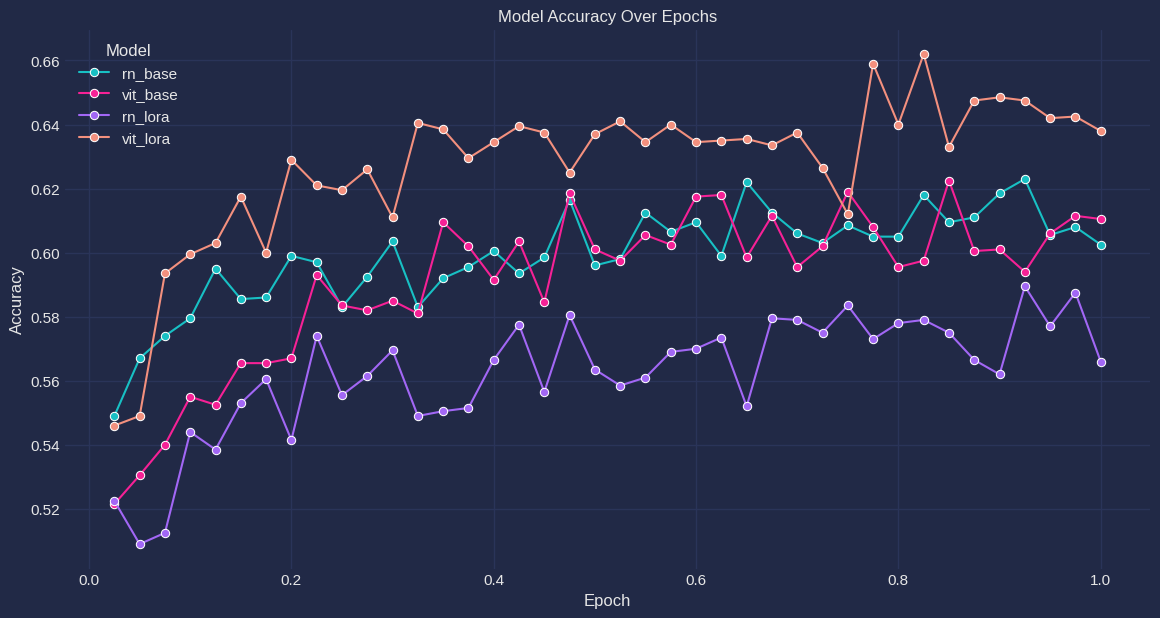

In [ ]:
# Create a line plot for Accuracy
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_melted[data_melted['Metric'] == 'Accuracy'],
             x='Epoch',
             y='Value',
             hue='Model',
             marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Model')
plt.grid(True)
plt.show()

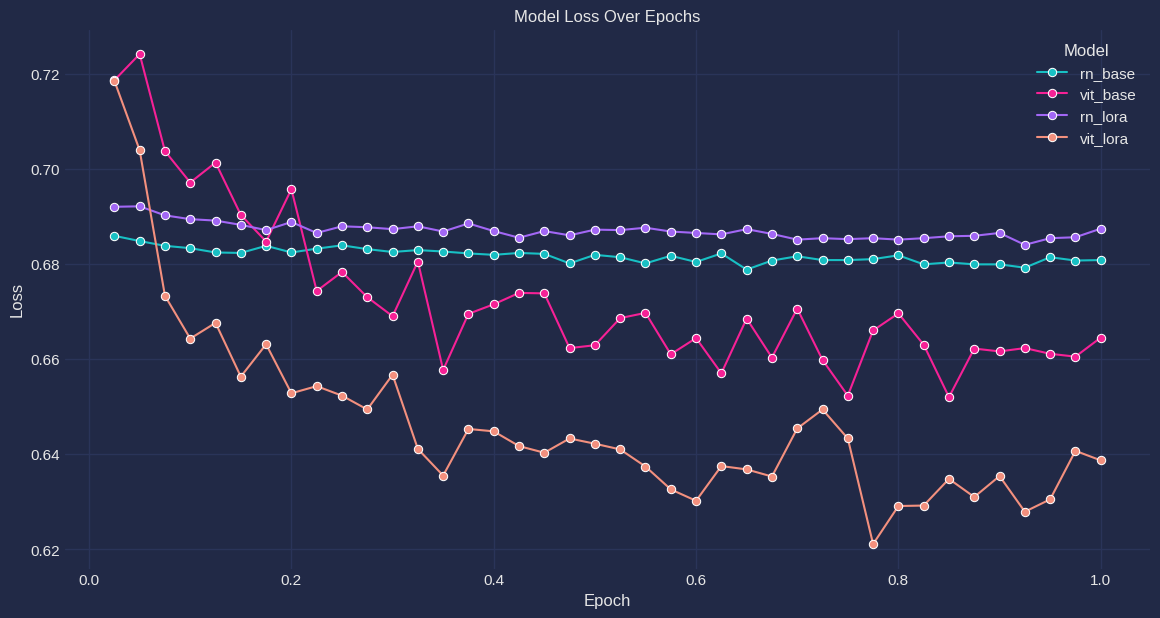

In [ ]:
# Create a line plot for Loss
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_melted[data_melted['Metric'] == 'Loss'],
             x='Epoch',
             y='Value',
             hue='Model',
             marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Model')
plt.grid(True)
plt.show()

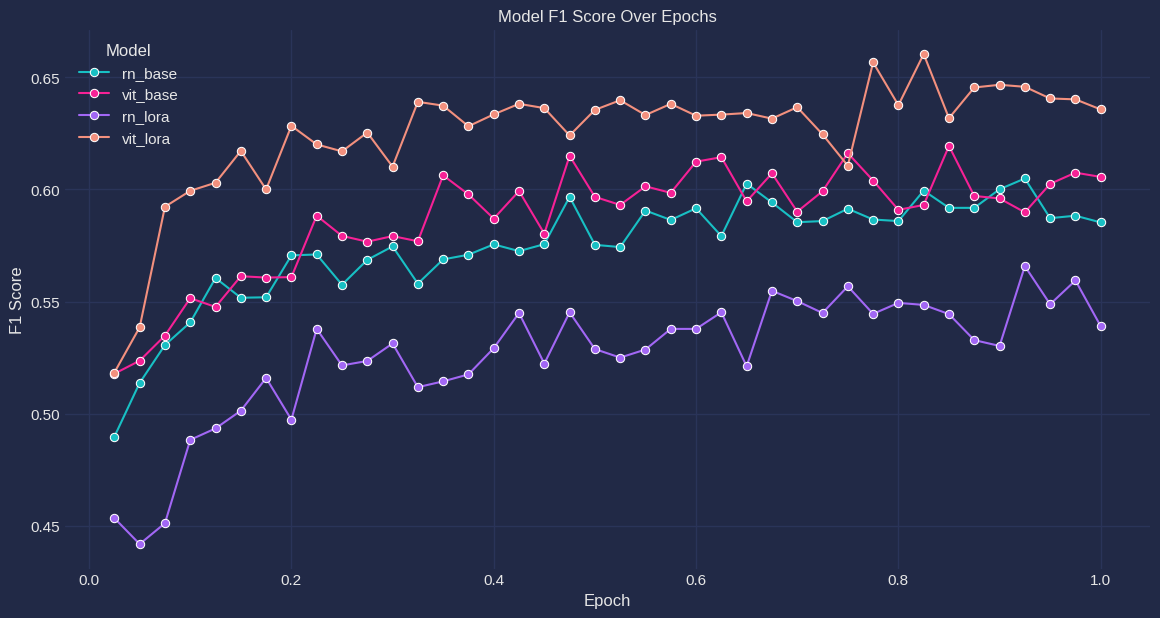

In [ ]:
# Create a line plot for F1 Score
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_melted[data_melted['Metric'] == 'F1'],
             x='Epoch',
             y='Value',
             hue='Model',
             marker='o')
plt.title('Model F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(title='Model')
plt.grid(True)
plt.show()

## Validation statistic

### First evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=8,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-8')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.71      0.39      0.50      1000
        real       0.58      0.84      0.69      1000

    accuracy                           0.61      2000
   macro avg       0.64      0.61      0.59      2000
weighted avg       0.64      0.61      0.59      2000


Confusion Matrix:
[[388 612]
 [159 841]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-8')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.63      0.60      1000
        real       0.58      0.51      0.54      1000

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000


Confusion Matrix:
[[634 366]
 [494 506]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-8')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.53      0.85      0.66      1000
        real       0.64      0.26      0.37      1000

    accuracy                           0.56      2000
   macro avg       0.58      0.56      0.51      2000
weighted avg       0.58      0.56      0.51      2000


Confusion Matrix:
[[850 150]
 [739 261]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-8')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.63      0.62      1000
        real       0.62      0.61      0.62      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000


Confusion Matrix:
[[630 370]
 [389 611]]


### Second evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=16,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-16')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.70      0.37      0.48      1000
        real       0.57      0.84      0.68      1000

    accuracy                           0.60      2000
   macro avg       0.63      0.60      0.58      2000
weighted avg       0.63      0.60      0.58      2000


Confusion Matrix:
[[370 630]
 [160 840]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-16')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.59      0.73      0.65      1000
        real       0.65      0.50      0.57      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[728 272]
 [498 502]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-16')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.53      0.93      0.67      1000
        real       0.71      0.16      0.26      1000

    accuracy                           0.55      2000
   macro avg       0.62      0.55      0.47      2000
weighted avg       0.62      0.55      0.47      2000


Confusion Matrix:
[[932  68]
 [837 163]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-16')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.63      0.71      0.66      1000
        real       0.66      0.58      0.62      1000

    accuracy                           0.64      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000


Confusion Matrix:
[[707 293]
 [420 580]]


### Third evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=24,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-24')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.71      0.42      0.53      1000
        real       0.59      0.82      0.69      1000

    accuracy                           0.62      2000
   macro avg       0.65      0.62      0.61      2000
weighted avg       0.65      0.62      0.61      2000


Confusion Matrix:
[[423 577]
 [176 824]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-24')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.59      0.71      0.65      1000
        real       0.64      0.52      0.57      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[708 292]
 [482 518]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-24')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.94      0.67      1000
        real       0.70      0.14      0.23      1000

    accuracy                           0.54      2000
   macro avg       0.61      0.54      0.45      2000
weighted avg       0.61      0.54      0.45      2000


Confusion Matrix:
[[940  60]
 [859 141]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-24')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.65      0.63      1000
        real       0.63      0.59      0.61      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000


Confusion Matrix:
[[654 346]
 [408 592]]


### Fourth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=32,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-32')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.68      0.45      0.55      1000
        real       0.59      0.79      0.68      1000

    accuracy                           0.62      2000
   macro avg       0.64      0.62      0.61      2000
weighted avg       0.64      0.62      0.61      2000


Confusion Matrix:
[[454 546]
 [210 790]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-32')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.60      0.69      0.64      1000
        real       0.63      0.54      0.58      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[689 311]
 [461 539]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-32')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.95      0.67      1000
        real       0.72      0.12      0.20      1000

    accuracy                           0.54      2000
   macro avg       0.62      0.54      0.44      2000
weighted avg       0.62      0.54      0.44      2000


Confusion Matrix:
[[954  46]
 [883 117]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-32')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.64      0.71      0.68      1000
        real       0.68      0.60      0.64      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000


Confusion Matrix:
[[715 285]
 [396 604]]


### Fifth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=40,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=40,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=40,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=40,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-40')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.69      0.41      0.51      1000
        real       0.58      0.82      0.68      1000

    accuracy                           0.61      2000
   macro avg       0.64      0.61      0.60      2000
weighted avg       0.64      0.61      0.60      2000


Confusion Matrix:
[[405 595]
 [180 820]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-40')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.61      0.73      0.66      1000
        real       0.66      0.53      0.59      1000

    accuracy                           0.63      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.63      0.63      2000


Confusion Matrix:
[[731 269]
 [468 532]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-40')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.66      0.32      0.43      1000
        real       0.55      0.83      0.66      1000

    accuracy                           0.58      2000
   macro avg       0.61      0.58      0.55      2000
weighted avg       0.61      0.58      0.55      2000


Confusion Matrix:
[[321 679]
 [166 834]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-40')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.64      0.72      0.68      1000
        real       0.68      0.60      0.64      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000


Confusion Matrix:
[[721 279]
 [403 597]]


### Sixth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=48,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=48,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=48,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=48,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-48')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.71      0.48      0.57      1000
        real       0.61      0.81      0.69      1000

    accuracy                           0.64      2000
   macro avg       0.66      0.64      0.63      2000
weighted avg       0.66      0.64      0.63      2000


Confusion Matrix:
[[481 519]
 [194 806]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-48')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.60      0.70      0.65      1000
        real       0.64      0.52      0.58      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[704 296]
 [476 524]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-48')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.65      0.28      0.39      1000
        real       0.54      0.85      0.66      1000

    accuracy                           0.57      2000
   macro avg       0.60      0.57      0.53      2000
weighted avg       0.60      0.57      0.53      2000


Confusion Matrix:
[[279 721]
 [147 853]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-48')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.64      0.71      0.67      1000
        real       0.67      0.60      0.63      1000

    accuracy                           0.65      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.65      0.65      2000


Confusion Matrix:
[[711 289]
 [403 597]]


### Seventh evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=56,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=56,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=56,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=56,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-56')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.70      0.45      0.55      1000
        real       0.60      0.80      0.68      1000

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.62      2000
weighted avg       0.65      0.63      0.62      2000


Confusion Matrix:
[[454 546]
 [196 804]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-56')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.61      0.71      0.66      1000
        real       0.65      0.55      0.60      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000


Confusion Matrix:
[[709 291]
 [449 551]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-56')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.67      0.30      0.41      1000
        real       0.55      0.85      0.67      1000

    accuracy                           0.58      2000
   macro avg       0.61      0.58      0.54      2000
weighted avg       0.61      0.58      0.54      2000


Confusion Matrix:
[[296 704]
 [145 855]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-56')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.65      0.74      0.69      1000
        real       0.70      0.60      0.65      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000


Confusion Matrix:
[[739 261]
 [398 602]]


### Eighth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=64,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=64,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=64,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=64,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-64')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.72      0.48      0.57      1000
        real       0.61      0.82      0.70      1000

    accuracy                           0.65      2000
   macro avg       0.67      0.65      0.64      2000
weighted avg       0.67      0.65      0.64      2000


Confusion Matrix:
[[476 524]
 [184 816]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-64')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.61      0.70      0.65      1000
        real       0.65      0.55      0.60      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.63      0.63      0.62      2000


Confusion Matrix:
[[700 300]
 [449 551]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-64')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.63      0.30      0.41      1000
        real       0.54      0.82      0.65      1000

    accuracy                           0.56      2000
   macro avg       0.59      0.56      0.53      2000
weighted avg       0.59      0.56      0.53      2000


Confusion Matrix:
[[301 699]
 [176 824]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-64')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.64      0.69      0.66      1000
        real       0.66      0.61      0.63      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000


Confusion Matrix:
[[687 313]
 [391 609]]


### Ninth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=72,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=72,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=72,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=72,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-72')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.69      0.46      0.55      1000
        real       0.59      0.79      0.68      1000

    accuracy                           0.63      2000
   macro avg       0.64      0.63      0.61      2000
weighted avg       0.64      0.63      0.61      2000


Confusion Matrix:
[[460 540]
 [209 791]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-72')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.61      0.70      0.65      1000
        real       0.65      0.54      0.59      1000

    accuracy                           0.62      2000
   macro avg       0.63      0.62      0.62      2000
weighted avg       0.63      0.62      0.62      2000


Confusion Matrix:
[[705 295]
 [457 543]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-72')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.98      0.68      1000
        real       0.81      0.09      0.17      1000

    accuracy                           0.54      2000
   macro avg       0.66      0.54      0.42      2000
weighted avg       0.66      0.54      0.42      2000


Confusion Matrix:
[[978  22]
 [907  93]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-72')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.64      0.71      0.67      1000
        real       0.68      0.60      0.64      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000


Confusion Matrix:
[[709 291]
 [395 605]]


### Tenth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=80,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=80,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=80,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=80,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-80')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.70      0.45      0.54      1000
        real       0.59      0.81      0.68      1000

    accuracy                           0.63      2000
   macro avg       0.64      0.63      0.61      2000
weighted avg       0.64      0.63      0.61      2000


Confusion Matrix:
[[446 554]
 [194 806]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-80')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.72      0.67      1000
        real       0.67      0.56      0.61      1000

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000


Confusion Matrix:
[[717 283]
 [437 563]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-80')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.95      0.67      1000
        real       0.72      0.12      0.21      1000

    accuracy                           0.54      2000
   macro avg       0.62      0.54      0.44      2000
weighted avg       0.62      0.54      0.44      2000


Confusion Matrix:
[[951  49]
 [876 124]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-80')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_


Classification Report:
              precision    recall  f1-score   support

        fake       0.65      0.73      0.69      1000
        real       0.69      0.61      0.65      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000


Confusion Matrix:
[[732 268]
 [390 610]]


## 📊 Current Insight on Performance (until 1st epoch)

### 🎓 During training:
-   **vit_lora** is the most accurate model, achieving the highest overall accuracy and lowest loss.
- **rn_lora** performs the worst, indicating that the chosen layer for LoRA fine-tuning might not benefit the ResNet architecture as much as it does for the Vision Transformer.
- Both **rn_base** and **vit_base** are relatively stable but do not perform as well as **vit_lora**.

### 🧑‍💻 During evaluation:
-   **rn_base** shows slightly better performance than **vit_base** in detecting real images, but **vit_base** is more balanced overall, especially for detecting fakes.
-   **rn_lora** suffers from a major imbalance, overfitting to fake images and severely underperforming on real images. This leads to reduced accuracy and poor recall for real images.
-   **vit_lora** performs significantly better than **rn_lora** and achieves the highest overall accuracy (~0.66). It also maintains a good balance between fake and real class detection, making it a better candidate for balanced detection tasks.

*These remarks are not the final version, further training iterations may help refine the performance of the models.*